In [1]:
import numpy as np
import torch
import torch.optim as optim
from torch.distributions.bernoulli import Bernoulli
from utils import *

from causalml.inference.meta import BaseDRRegressor
from sklearn.linear_model import LinearRegression

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from torch.optim import lr_scheduler 
from torch.nn import init 
import os 


# from tqdm.notebook import tqdm

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def manipulation_true(u, v, n, card_u, model, true_card_u, c=0.05):
    v_target = v.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    u_target = torch.eye(card_u).repeat(n, 1)    
    x_target = torch.cat((u_target, v_target), dim=1)
    pi = model(x_target).view(-1, card_u)

    u_target_true = torch.eye(true_card_u).repeat(n, 1)        
    u_init = u.repeat_interleave(torch.tensor([true_card_u]).repeat_interleave(n), dim=0)
    _, u_init_category = torch.where(u_init == 1)
    _, u_taregt_category = torch.where(u_target_true == 1)
    cost = torch.abs(u_taregt_category - u_init_category).view(-1, true_card_u)
    inputs = torch.cat((v, pi), dim=1)
        
    pi = pi.repeat_interleave(u_coarse_vol, dim=1) # similar true u level corresponds to the same propensity    
    
    if true_card_u % card_u != 0: 
        # print(true_card_u, card_u)
        pi = pi[:,:true_card_u]
    
    # print(cost.shape, pi.shape)
    utility = pi - c * cost / u_coarse_vol # reduce the manipulation cost coefficient, since there are more levels
    true_index = utility.argmax(dim=1)
    true_u_shift = torch.zeros((n, true_card_u))
    true_u_shift[torch.arange(n), true_index] = 1
    
    index = true_index // u_coarse_vol # transform the true u index into coarse index
    u_shift = torch.zeros((n, card_u))
    u_shift[torch.arange(n), index] = 1    
    
    return inputs, index.view(-1, 1), u_shift, true_index.view(-1, 1), true_u_shift



def manipulation(u, v, n, card_u, model, c=0.05):
    v_target = v.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    u_target = torch.eye(card_u).repeat(n, 1)
    x_target = torch.cat((u_target, v_target), dim=1)
    pi = model(x_target).view(-1, card_u)
    u_init = u.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    _, u_init_category = torch.where(u_init == 1)
    _, u_taregt_category = torch.where(u_target == 1)
    cost = torch.abs(u_taregt_category - u_init_category).view(-1, card_u)
    inputs = torch.cat((v, pi), dim=1)
    utility = pi - c * cost
    print(pi.shape, cost.shape)    
    index = utility.argmax(dim=1)
    u_shift = torch.zeros((n, card_u))
    u_shift[torch.arange(n), index] = 1
    return inputs, index.view(-1, 1), u_shift


def allocation_policy(num_input, num_hidden):
    model = nn.Sequential(
        nn.Linear(num_input, num_hidden),
        nn.ReLU(),
        nn.Linear(num_hidden, 1),        
        nn.Sigmoid()
    )
    return model



def shifted_distribution(num_input, num_hidden, num_strata):
    model = nn.Sequential(
        nn.Linear(num_input, num_hidden),
        nn.ReLU(),
        nn.Linear(num_hidden, num_hidden),
        nn.ReLU(),
        nn.Linear(num_hidden, num_strata)
    )
    return model

In [9]:
mani_u_list_mm = []
stra_grad_list = [] 

model_pi_list = []
model_prob_list = []


def StrategicGD_coarse(seed, dim_v, card_u, beta, trans, H, f, len_seq, num_epoch, T, n, n_eval, lr_pi = 0.01, lr_prob = 0.01, cost_coef = 0.05):
    print(seed)
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")
    
    torch.manual_seed(1)
    np.random.seed(1)

    num_hiddens_pi = 2 * (dim_v + card_u)
    model_pi = allocation_policy(dim_v + card_u, num_hiddens_pi)

    num_hiddens_prob = 2 * (dim_v + card_u)
    model_prob = shifted_distribution(card_u, num_hiddens_prob, card_u)
    
    patience = 3

    cate_learner = BaseDRRegressor(learner=LinearRegression(), treatment_effect_learner=LinearRegression())
    
    t = 0
    seq_revenue = []
    seq_loss = []
    seq_val = []
    seq_inputs = []
    seq_category = []
    seq_x = []
    seq_z = []
    seq_y = []
    seq_pi = []

    seq_x_true = []
    
    optimizer_pi = optim.Adam(model_pi.parameters(), lr=lr_pi)    
    
    
    for t in range(H):
        u, v = dataset[seed][t]

        # inputs, u_category, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)
        inputs, u_category, u_shift, true_u_category, true_u_shift  = manipulation_true(u, v, n, card_u, model_pi, true_card_u, c=cost_coef)
        
        
        mani_u_list_mm.append(u_shift)
            
        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        x_true = torch.cat((true_u_shift, v), dim=1)
        
        pi = model_pi(x)
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x_true, z, n, beta, seed=seed)
        
        # inputs = torch.cat([u, inputs], dim=1)
        inputs = inputs[:,-card_u:]
        
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)
        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)
        
        seq_x_true.append(x_true)

        cate_fit(seq_x_true, seq_y, seq_z, seq_pi, cate_learner)
        tau = cate_predict(x_true, pi, cate_learner).cuda()    
        

        revenue = - torch.mean(pi * tau.detach())

        optimizer_pi.zero_grad()
        revenue.backward()
        
        grads = []
        for param in model_pi.parameters():
            grads.append(param.grad.view(-1))
        grads = torch.cat(grads)
        stra_grad_list.append(grads)         
        
        optimizer_pi.step()

        # evaluation of allocation policy    


        _, _, u_eval_shift, _, true_u_eval_shift = manipulation_true(u_eval, v_eval, n_eval, card_u, model_pi, true_card_u, c=cost_coef)                
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        true_x_eval = torch.cat((true_u_eval_shift, v_eval), dim=1)        
        pi_eval = model_pi(x_eval)
        tau_eval = true_x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())
        

    # training of the shifted distribution
    stacked_inputs = torch.cat(seq_inputs, dim=0)
    stacked_category = torch.cat(seq_category, dim=0)

    random_indices = torch.randperm(stacked_inputs.shape[0])
    stacked_inputs = stacked_inputs[random_indices]
    stacked_category = stacked_category[random_indices]

    n_sample = int(stacked_inputs.shape[0] * 0.8)

    train_inputs = stacked_inputs[0:n_sample, :]
    train_category = stacked_category[0:n_sample, :]
    val_inputs = stacked_inputs[n_sample:, :]
    val_category = stacked_category[n_sample:, :]

    early_stop_counter = 0
    best_val_loss = float('inf')

    loss_function = nn.CrossEntropyLoss()
    optimizer_prob = optim.SGD(model_prob.parameters(), lr=lr_prob)

    
    for epoch in range(num_epoch):
        loss = loss_function(model_prob(train_inputs), train_category.view(-1))
        optimizer_prob.zero_grad()
        loss.backward()
        optimizer_prob.step()
        seq_loss.append(loss.item())
        loss_val = loss_function(model_prob(val_inputs), val_category.view(-1))
        seq_val.append(loss_val.item())
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break

    print("Behavior Model Final Training Loss: %.3f"%loss_val.item())
    print("End Epoch: %d"%epoch)
    
    # optimizer_pi = optim.Adamax(model_pi.parameters(), lr=lr_pi)
    optimizer_pi = optim.Adagrad(model_pi.parameters(), lr=lr_pi)    
    # optimizer_pi = optim.SGD(model_pi.parameters(), lr=lr_pi, momentum=0.5)       
    # optimizer_pi = optim.SGD(model_pi.parameters(), lr=lr_pi)   
    
    while True:
        t = t + 1
        u, v = dataset[seed][t]
        # inputs, u_category, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)  
#         inputs = torch.cat([inputs, u], dim=1) # add original u into input
        inputs, u_category, u_shift, true_u_category, true_u_shift  = manipulation_true(u, v, n, card_u, model_pi, true_card_u, c=cost_coef)
            
        inputs = inputs[:,-card_u:]      
        
        # record u after manipulation
        mani_u_list_mm.append(u_shift)                
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)

        if len(seq_inputs) > len_seq:
            seq_inputs.pop(0)
            seq_category.pop(0)

        # train model pi
        x = torch.cat((u_shift, v), dim=1) 
        x_true = torch.cat((true_u_shift, v), dim=1)        
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x_true, z, n, beta, seed=seed)
        
        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        pi = model_pi(x)  
        seq_pi.append(pi) 
        
        log_prob = nn.LogSoftmax(dim=1)(model_prob(inputs))[torch.arange(n), u_category.view(-1)]              
        tau = cate_predict(x_true, pi, cate_learner).cuda()     
        # tau = x @ beta                                           
        revenue = - torch.mean(pi * tau) -  torch.mean(pi.detach() * tau * log_prob)            
        optimizer_pi.zero_grad()
        revenue.backward(retain_graph=True)        
        
        
        # grads = []
        # for param in model_pi.parameters():
        #     grads.append(param.grad.view(-1))
        # grads = torch.cat(grads)
        # stra_grad_list.append(grads)         
        
        
        optimizer_pi.step()
        # pi_lr_sch.step()

        # evaluation of allocation policy

        # _, _, u_eval_shift = manipulation(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)
        _, _, u_eval_shift, _, true_u_eval_shift = manipulation_true(u_eval, v_eval, n_eval, card_u, model_pi, true_card_u, c=cost_coef)        
        
        
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        true_x_eval = torch.cat((true_u_eval_shift, v_eval), dim=1)        
        pi_eval = model_pi(x_eval)
        tau_eval = true_x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())

        if t >= T - 1:
            break
            
    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(seq_revenue)

    plt.subplot(1, 2, 2)
    plt.plot(seq_loss, label='train loss')
    plt.plot(seq_val, label='val loss')
    plt.legend(fontsize = 20)
    plt.savefig("coarse_imgs/seed{}_card{}_true_card_{}.pdf".format(seed, card_u, true_card_u))
    plt.show()
    
    model_pi_list.append(model_pi)
    model_prob_list.append(model_prob)
    
    return seq_revenue, seq_loss, seq_val

In [5]:
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda")
torch.manual_seed(1)
dim_v = 20

true_card_u = 50

# coarse_spg_cv_list = []

beta = torch.tensor(list(np.linspace(-5, 5, true_card_u)) + list(np.random.normal(0, 1, size = (dim_v,))), dtype=torch.float32).view(-1, 1)

trans = torch.rand((dim_v, true_card_u), dtype=torch.float32)

H = 100
len_seq = 100
num_epoch = 800

T = 300
n = 4000
n_eval = 10000
repeat_num = 5

cost_coef = 0.05

epoch = list(range(T)) * 10

# fix samples for policy eval 
u_eval, v_eval = x_generate(n_eval, dim_v, trans, seed=0) # fix eval


# seed_list = range(5)

seed_list = range(10)
dataset = {}
for s in seed_list:
    dataset[s] = [x_generate(n, dim_v, trans, seed=s) for i in range(T)]

10
0
Behavior Model Final Training Loss: 1.780
End Epoch: 799


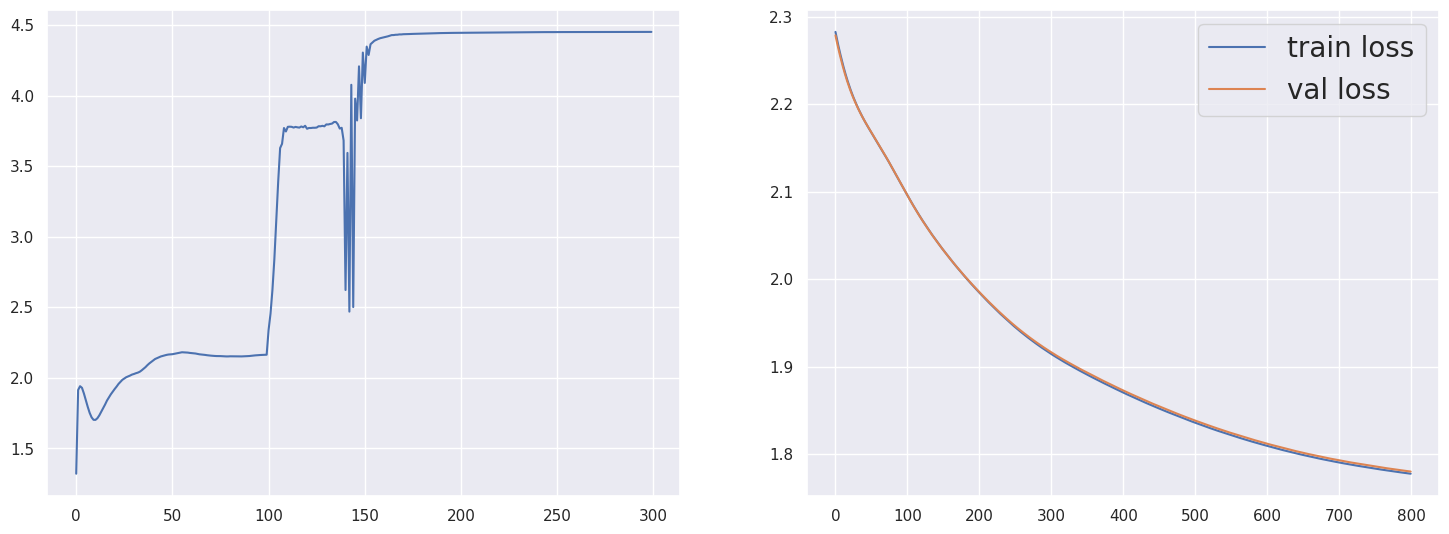

1
Behavior Model Final Training Loss: 1.779
End Epoch: 799


KeyboardInterrupt: 

In [13]:
coarse_spg_cv_list = []


# for card_u in [8, 6, 4, 2]:
for card_u in [10, 5, 4, 3, 2]:
    print(card_u)   
    # u_coarse_vol = (true_card_u) // card_u # ceiling
    u_coarse_vol = (true_card_u + card_u - 1) // card_u # ceiling

    spg_cv = []
    init_seed = 0


    for rep_index in range(3):
        spg_curve = StrategicGD_coarse(cost_coef=cost_coef, f=10000, lr_pi=0.1, lr_prob=0.1, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                

        coarse_spg_cv_list.append(spg_curve)    

In [8]:
torch.save(coarse_spg_cv_list, "coarse_spg_cv_list_true_2-10card{}.pkl".format(true_card_u))

10
0
Behavior Model Final Training Loss: 1.792
End Epoch: 799


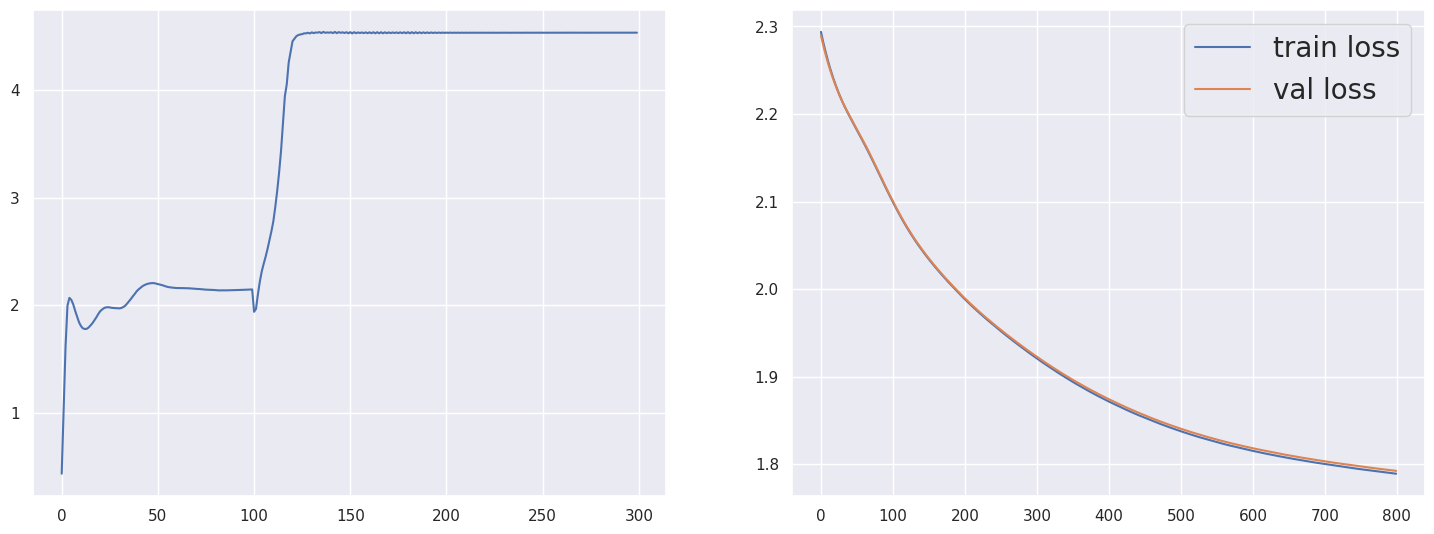

1
Behavior Model Final Training Loss: 1.763
End Epoch: 799


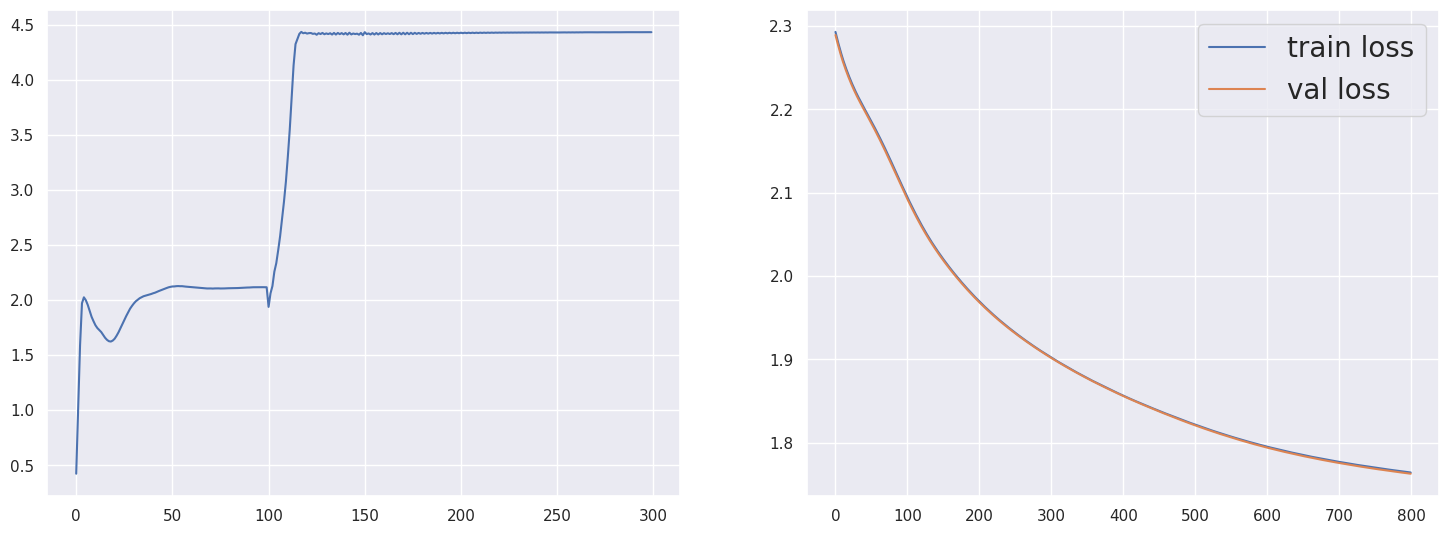

2
Behavior Model Final Training Loss: 1.787
End Epoch: 799


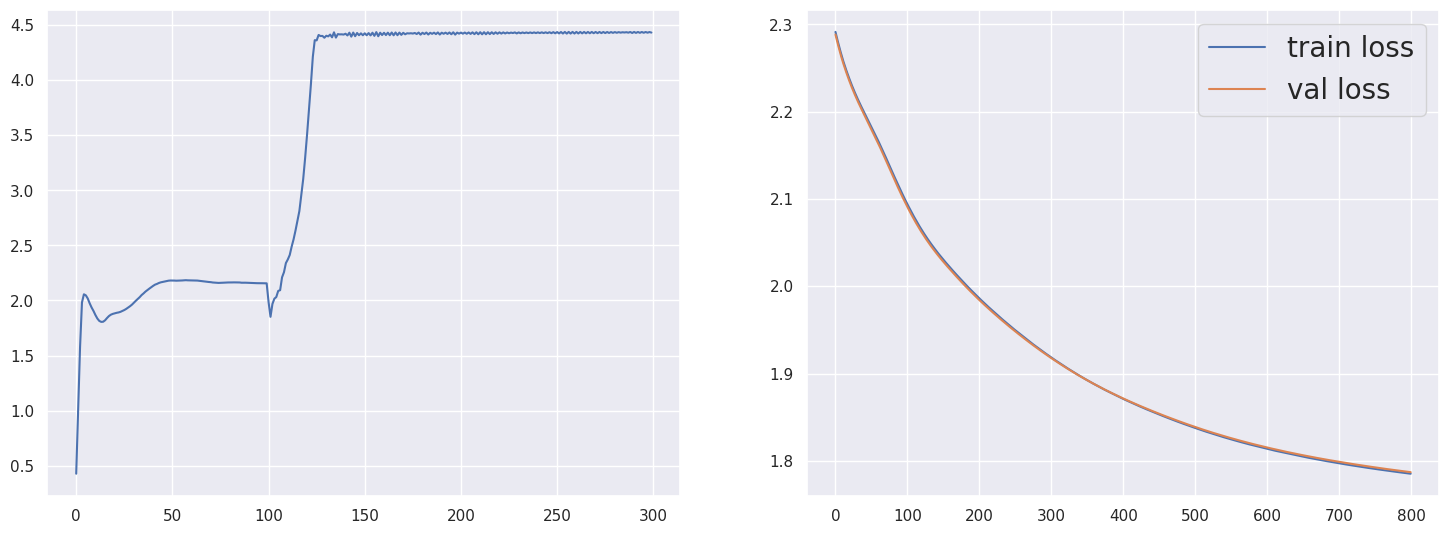

3
Behavior Model Final Training Loss: 1.782
End Epoch: 799


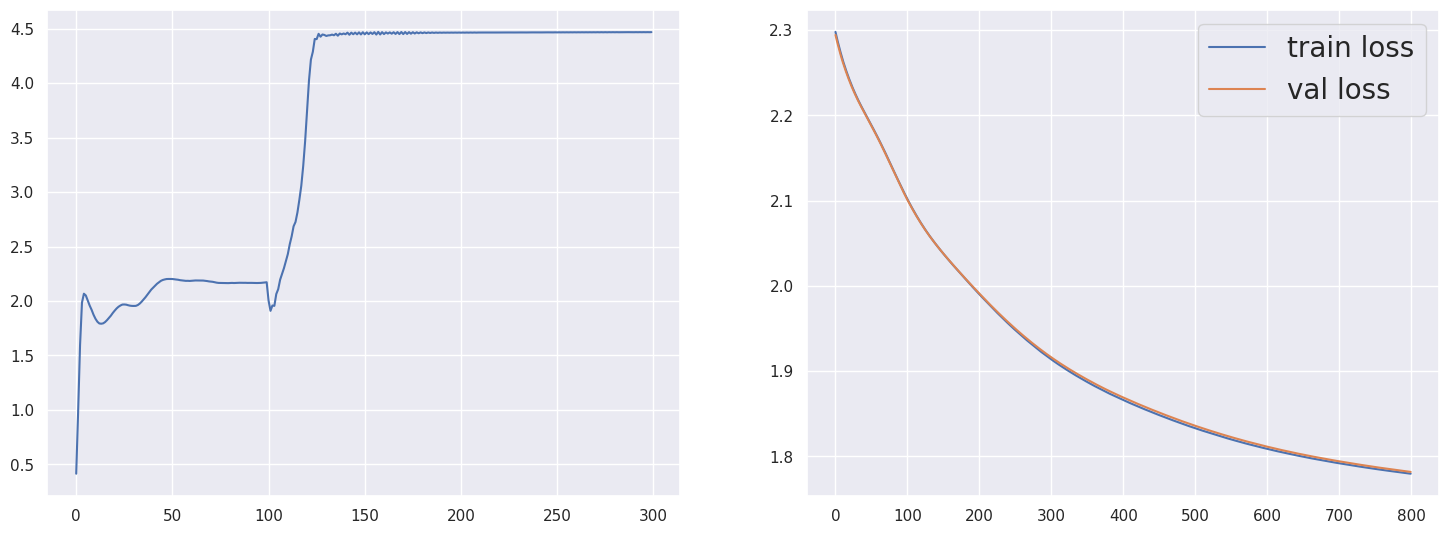

4
Behavior Model Final Training Loss: 1.795
End Epoch: 799


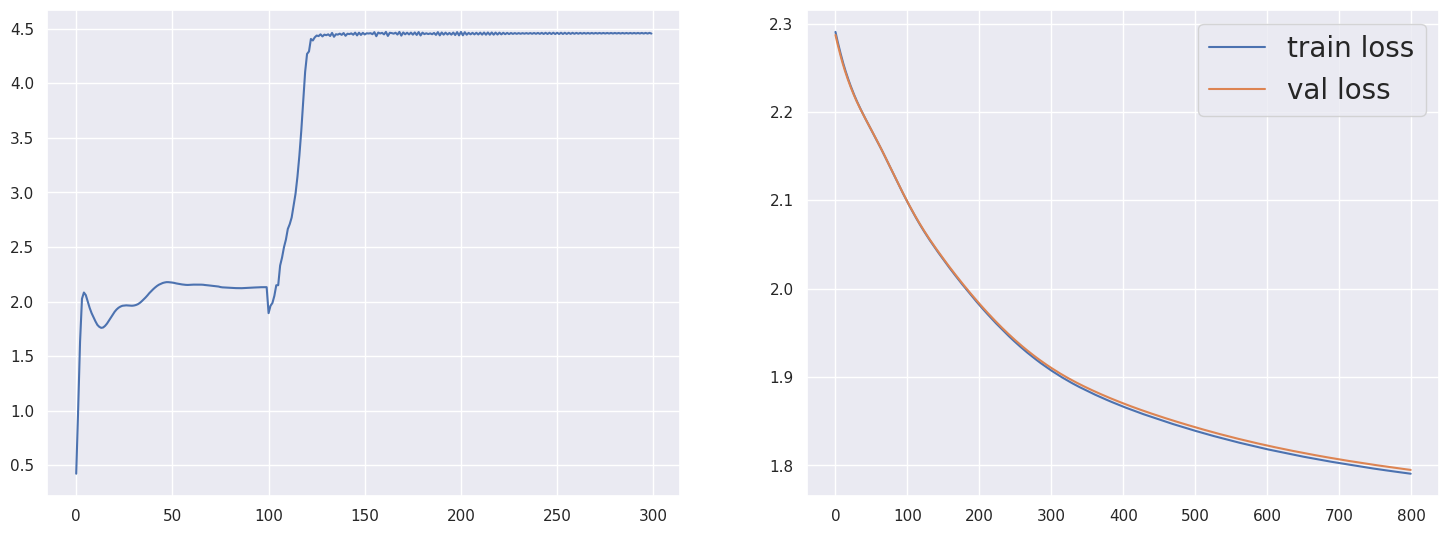

5
0
Behavior Model Final Training Loss: 1.226
End Epoch: 799


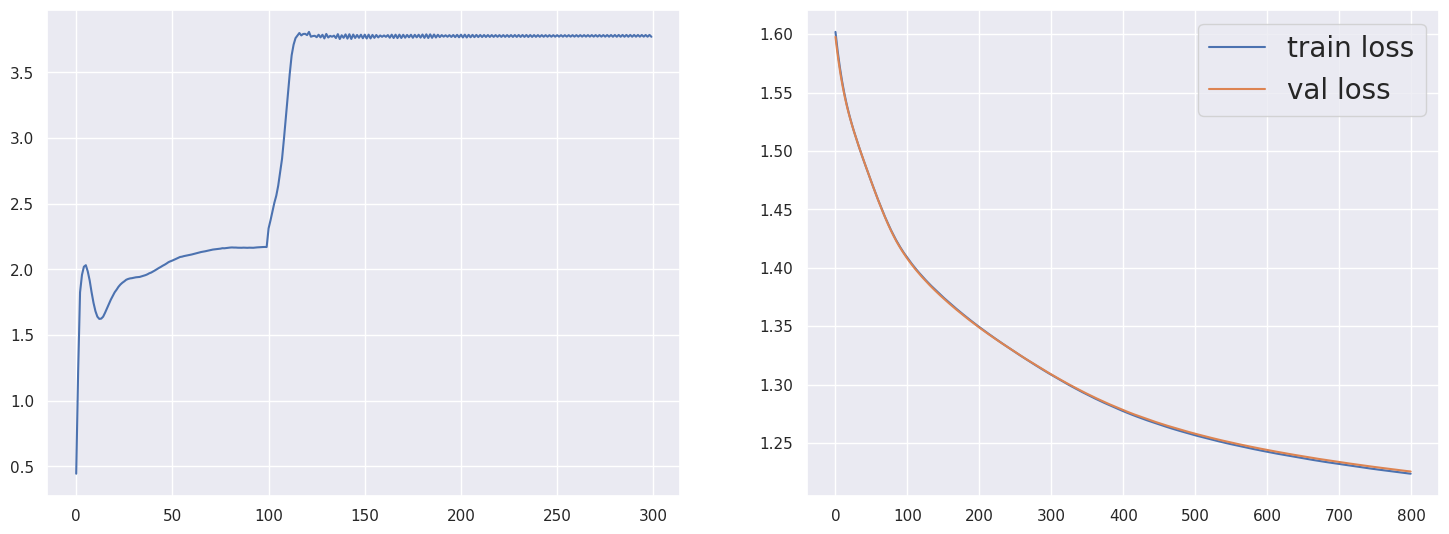

1
Behavior Model Final Training Loss: 1.211
End Epoch: 799


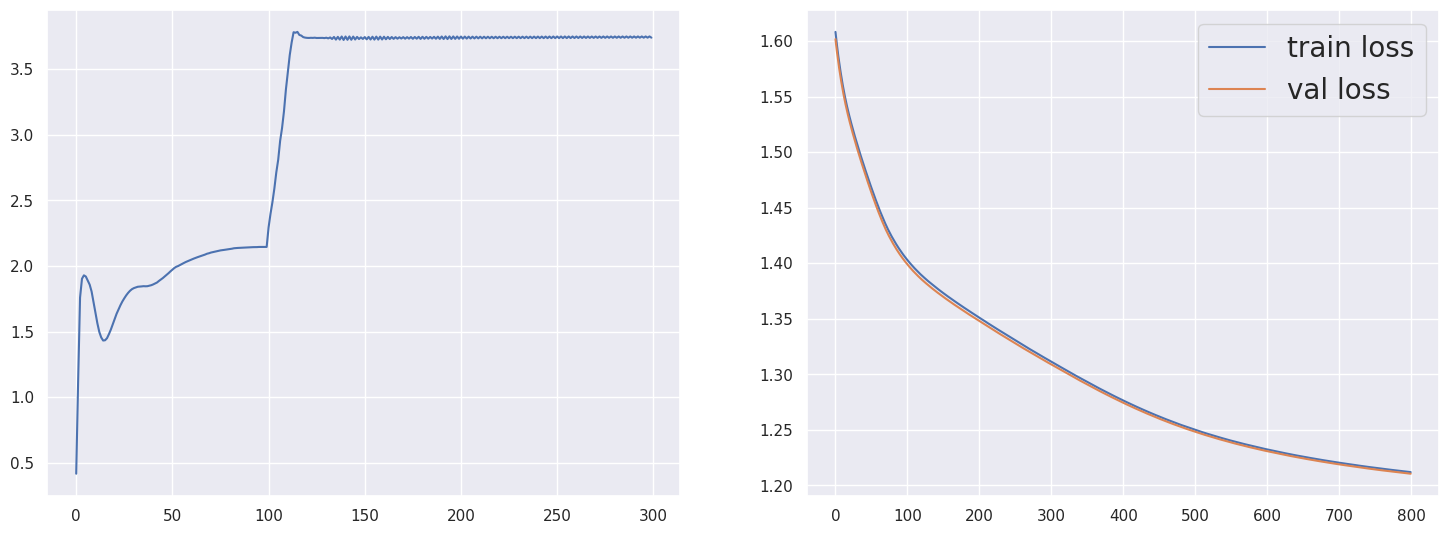

2
Behavior Model Final Training Loss: 1.215
End Epoch: 799


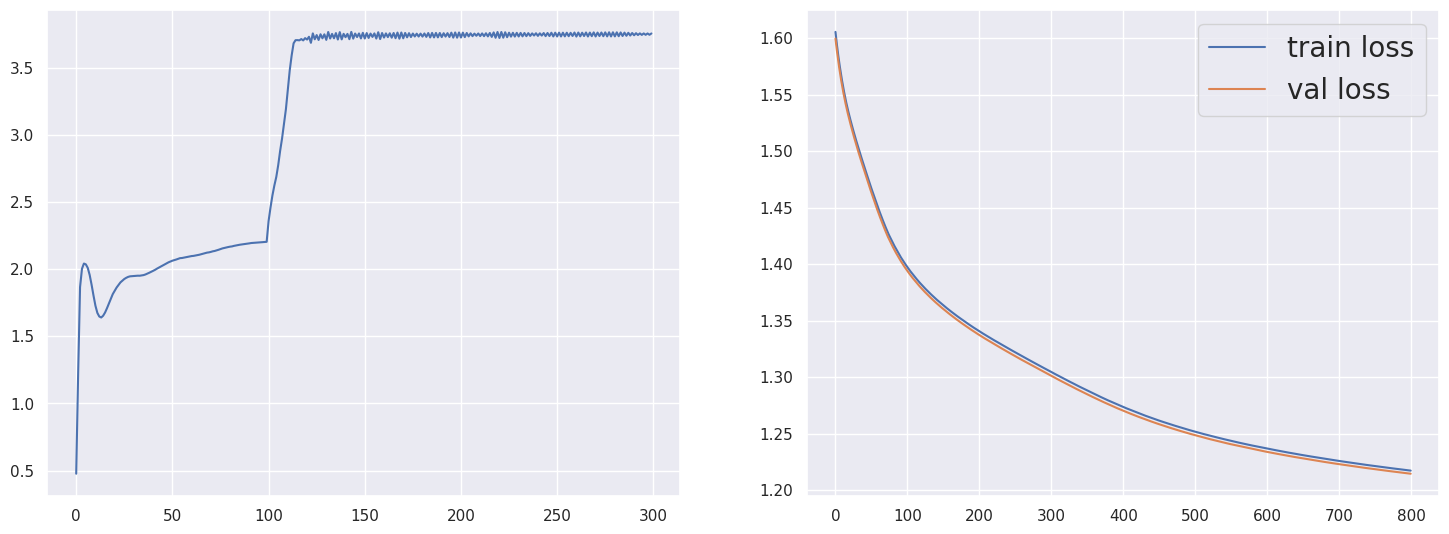

3
Behavior Model Final Training Loss: 1.184
End Epoch: 799


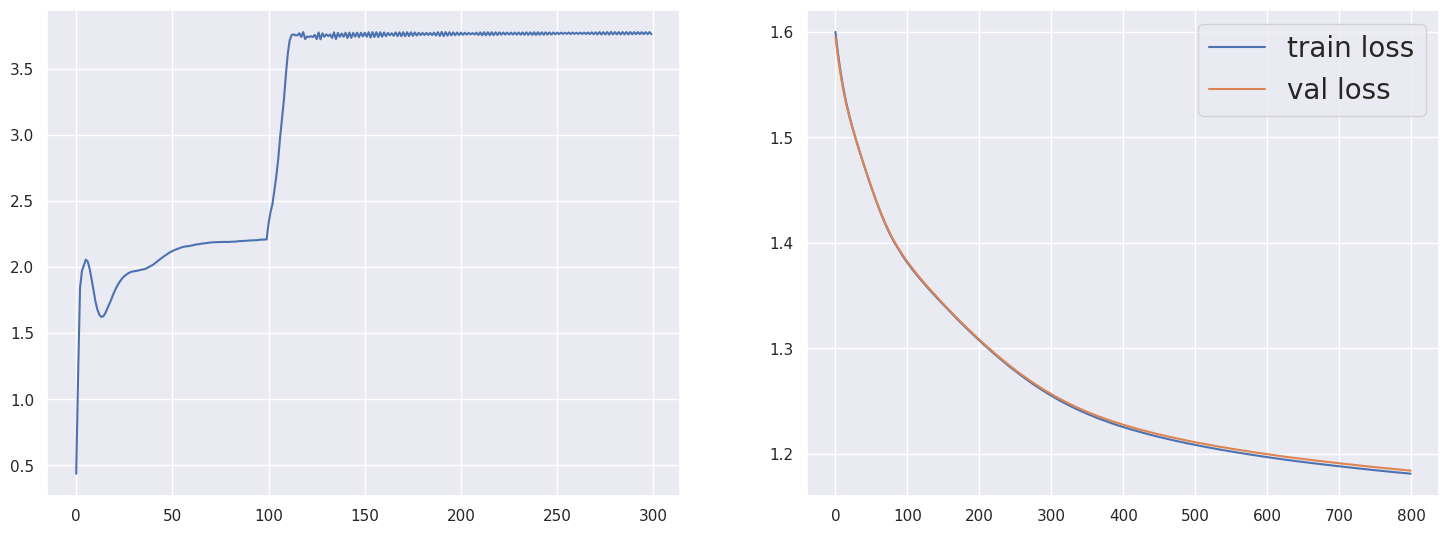

4
Behavior Model Final Training Loss: 1.204
End Epoch: 799


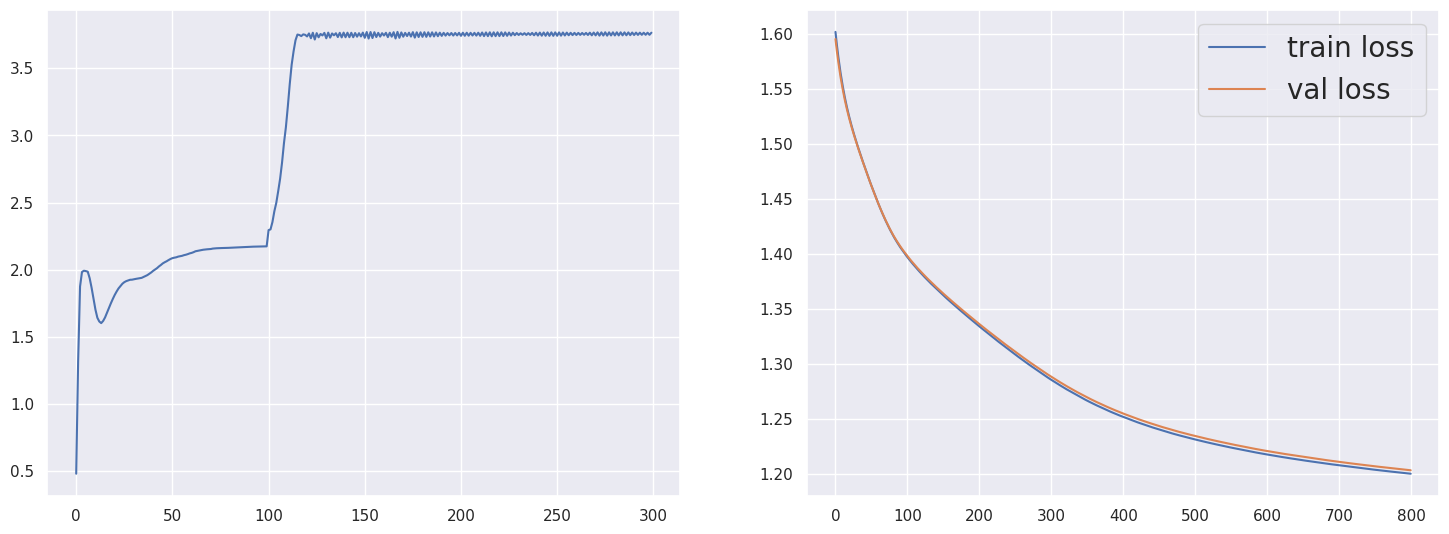

4
0
Behavior Model Final Training Loss: 1.035
End Epoch: 799


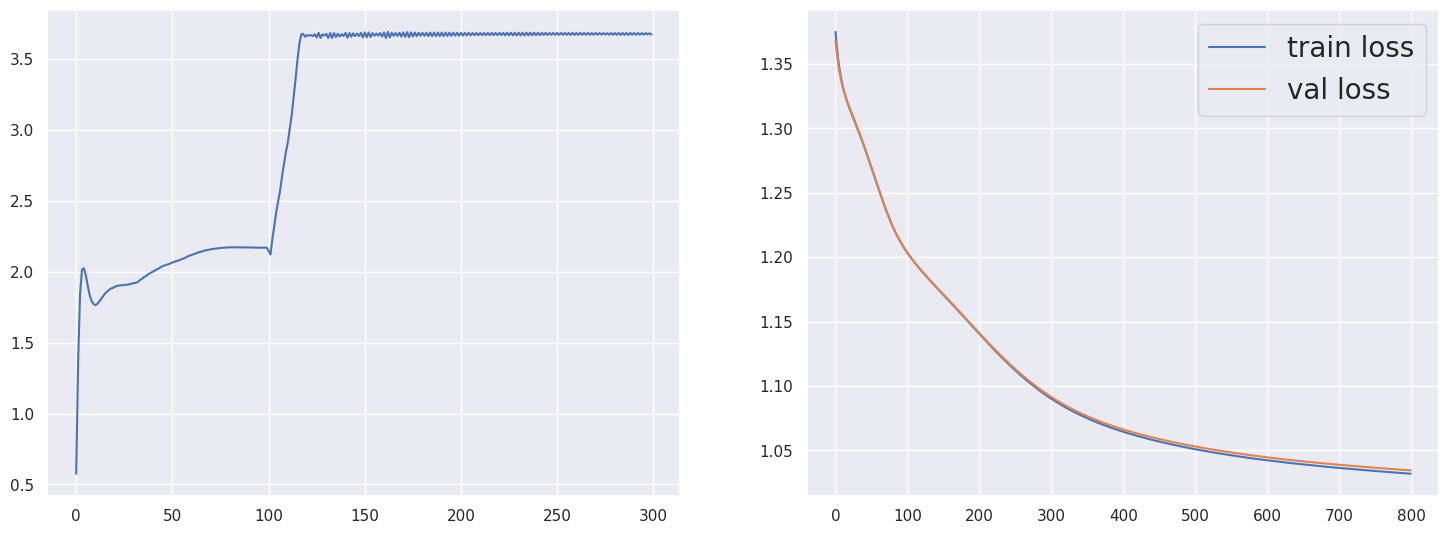

1
Behavior Model Final Training Loss: 1.034
End Epoch: 799


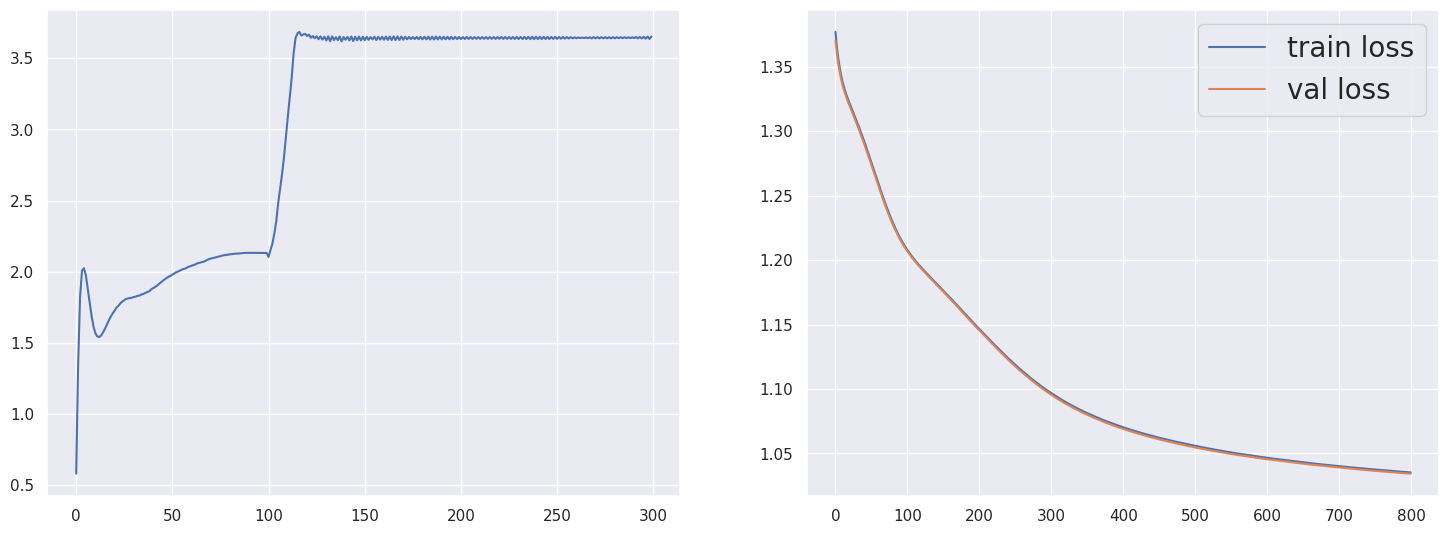

2
Behavior Model Final Training Loss: 1.024
End Epoch: 799


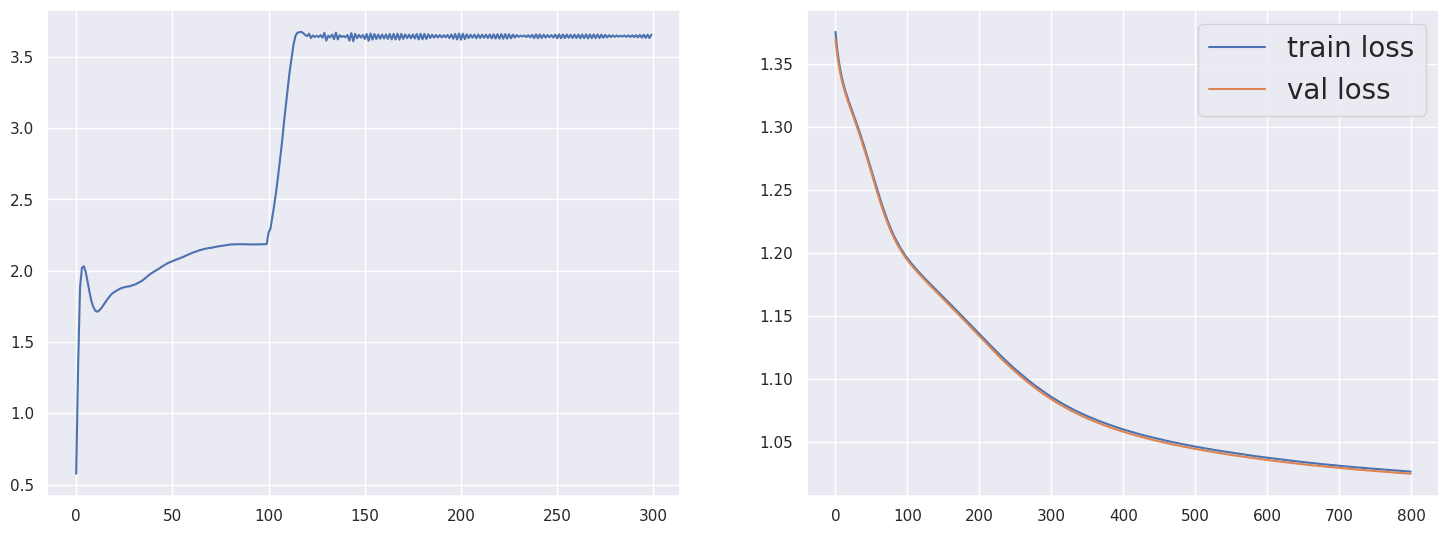

3
Behavior Model Final Training Loss: 1.006
End Epoch: 799


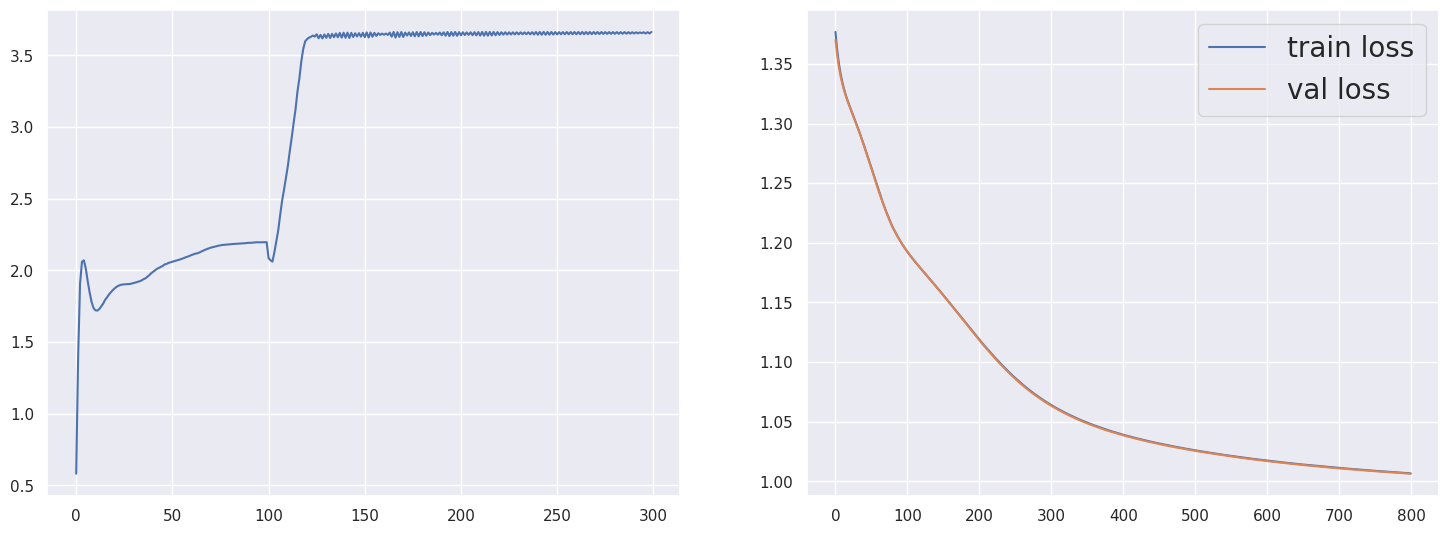

4
Behavior Model Final Training Loss: 1.015
End Epoch: 799


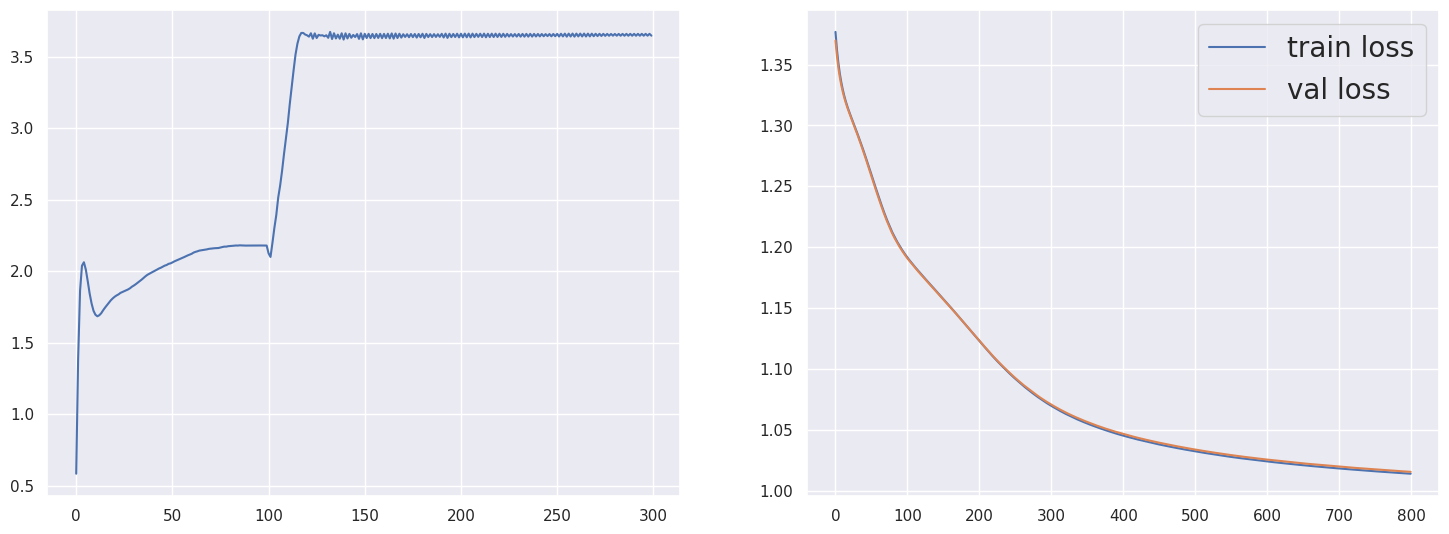

3
0
Behavior Model Final Training Loss: 0.820
End Epoch: 613


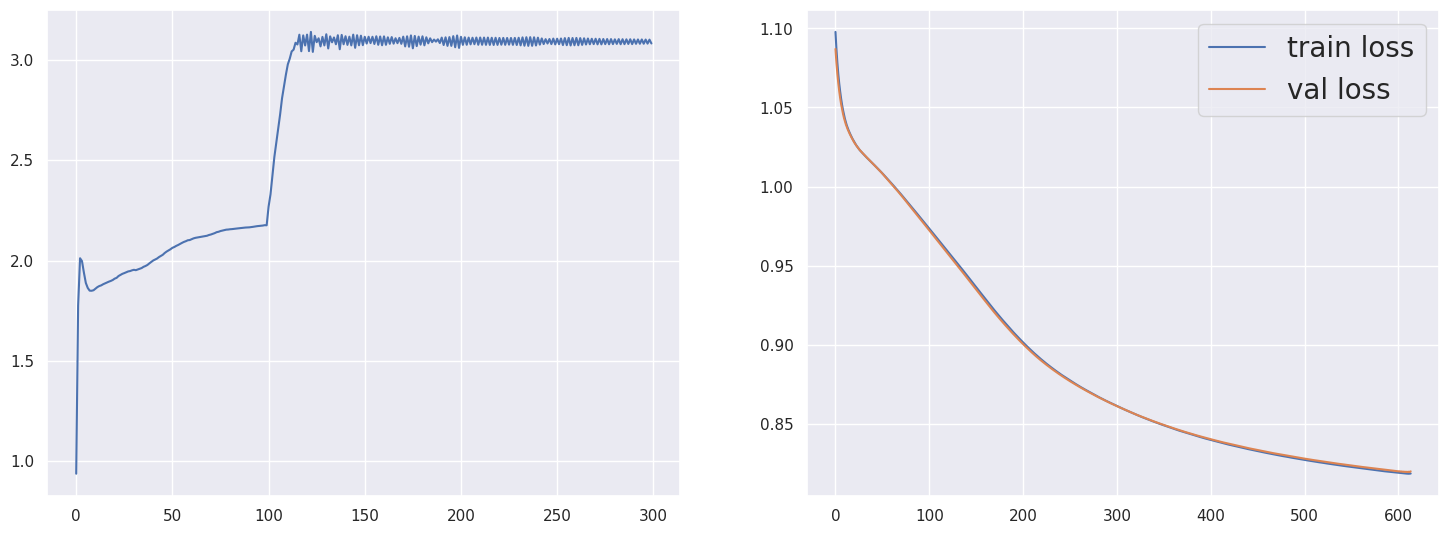

1
Behavior Model Final Training Loss: 0.802
End Epoch: 617


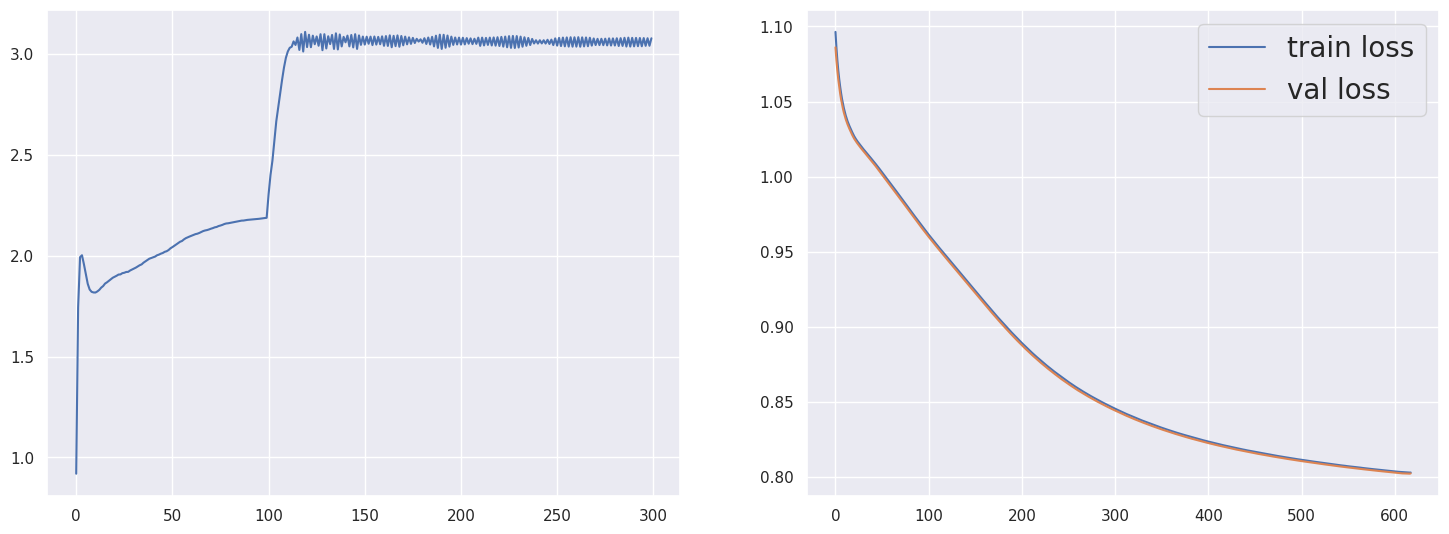

2
Behavior Model Final Training Loss: 0.803
End Epoch: 652


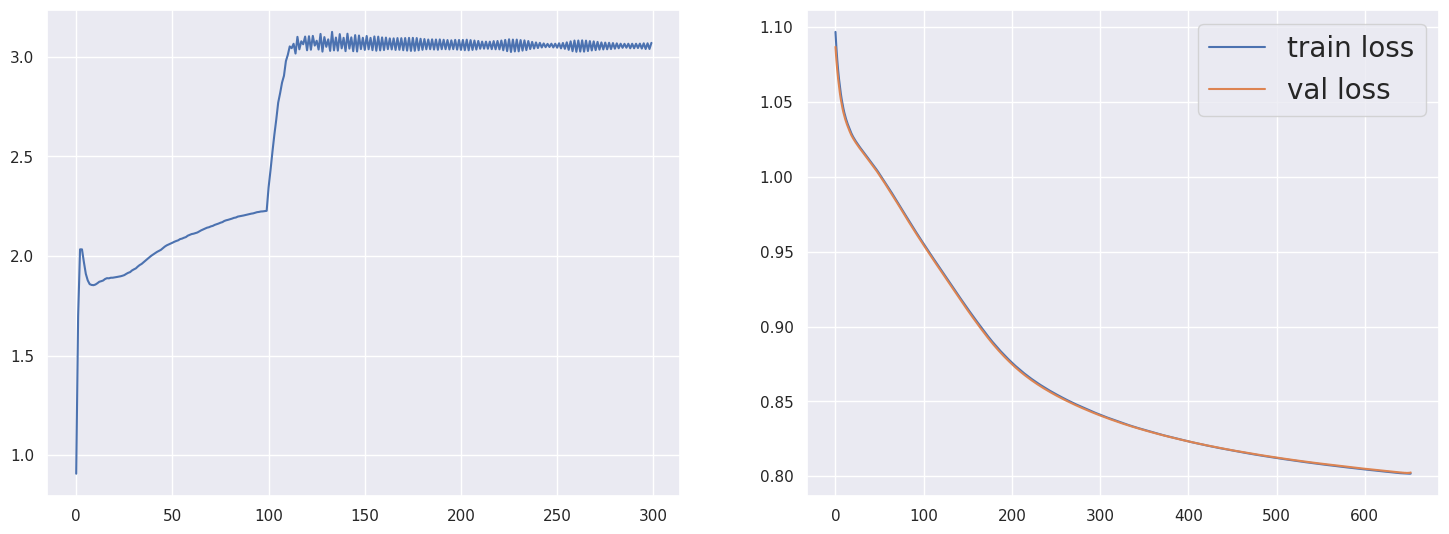

3
Behavior Model Final Training Loss: 0.814
End Epoch: 615


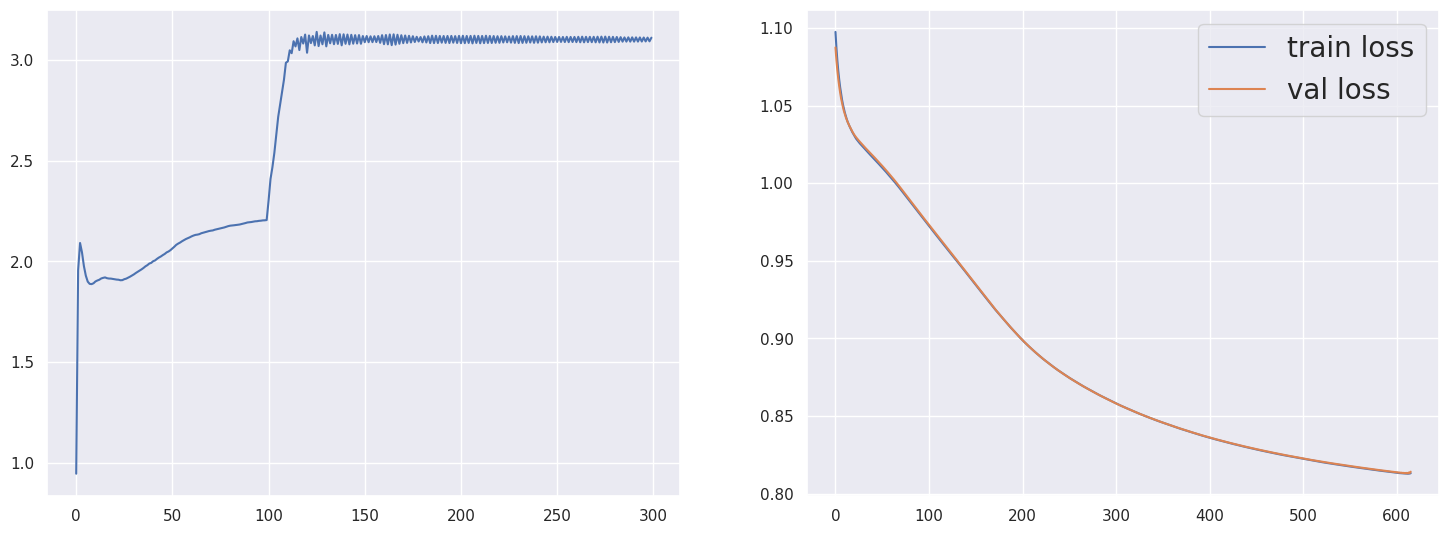

4
Behavior Model Final Training Loss: 0.803
End Epoch: 655


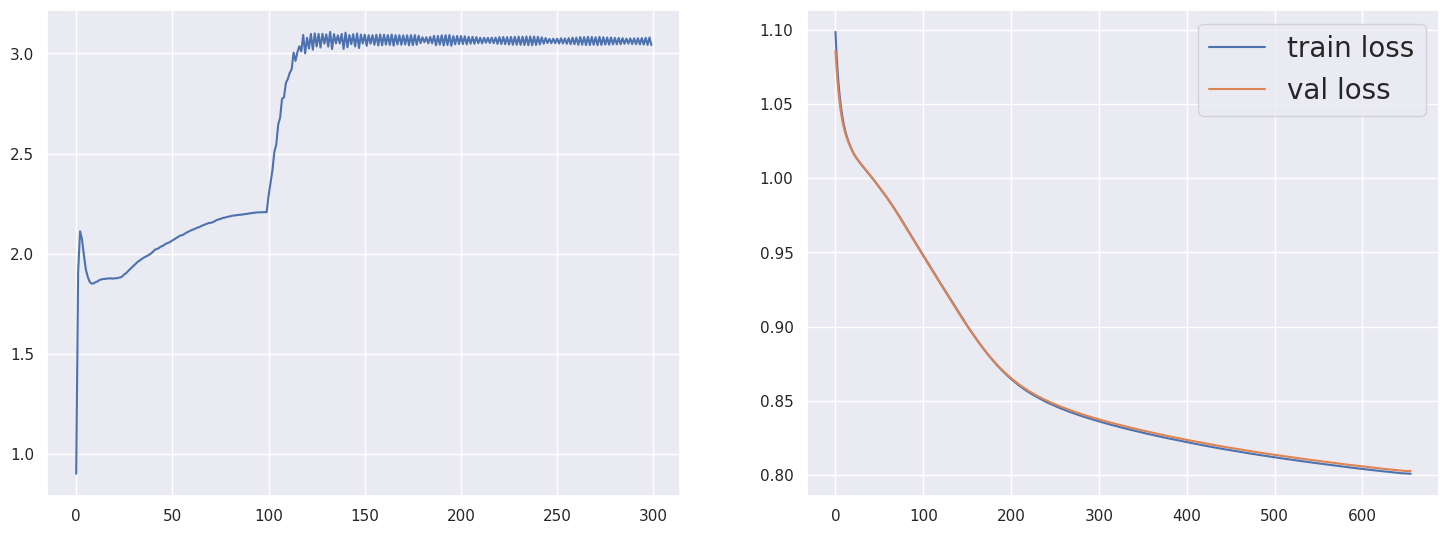

2
0
Behavior Model Final Training Loss: 0.504
End Epoch: 644


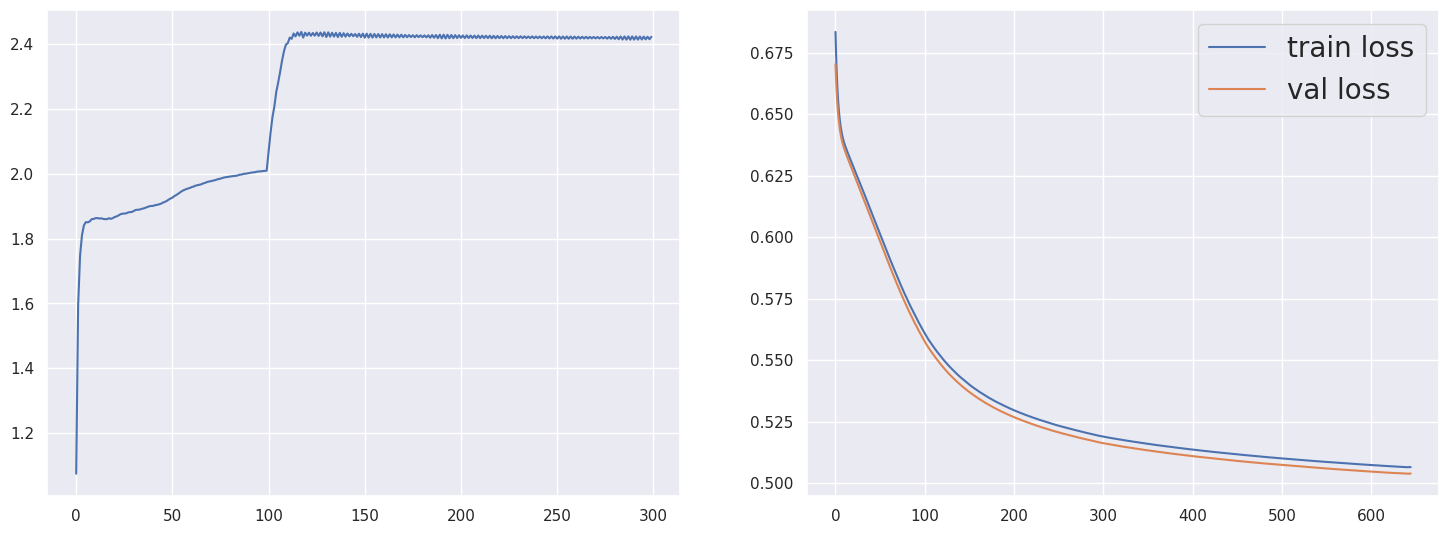

1
Behavior Model Final Training Loss: 0.508
End Epoch: 654


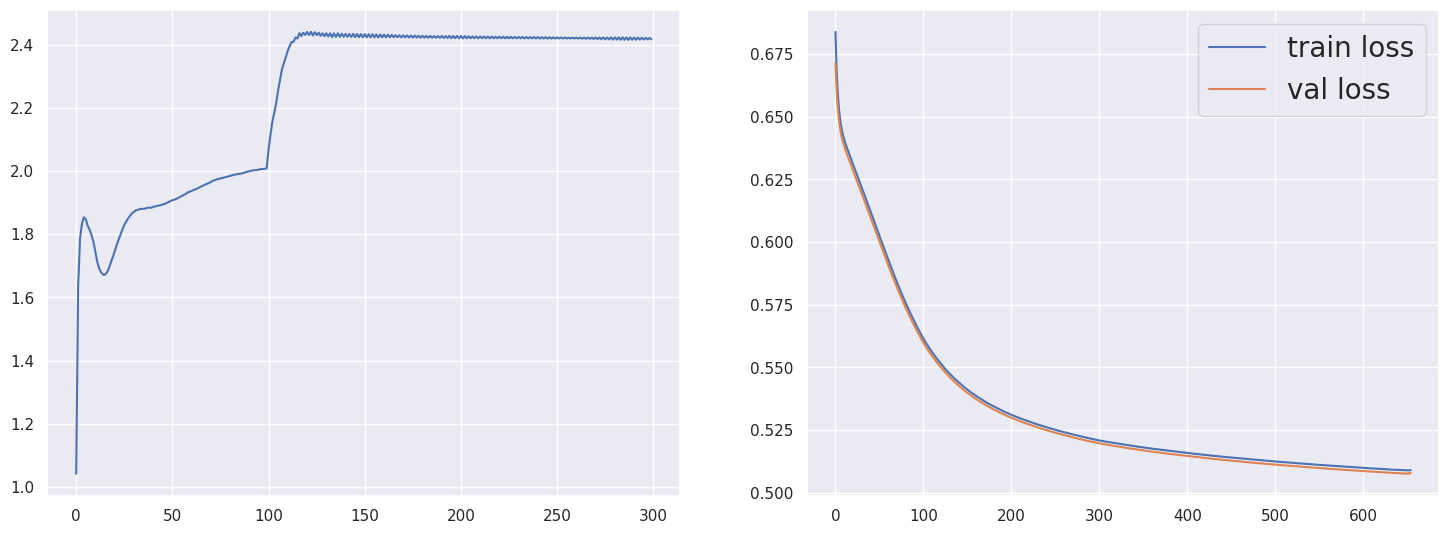

2
Behavior Model Final Training Loss: 0.503
End Epoch: 671


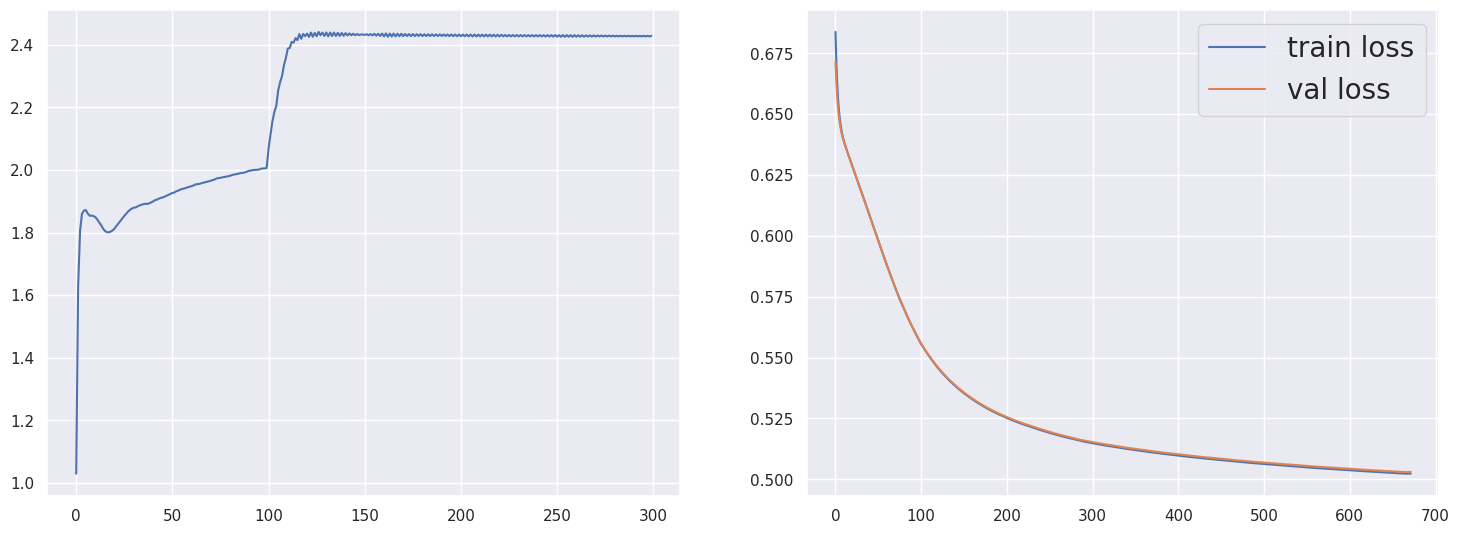

3
Behavior Model Final Training Loss: 0.503
End Epoch: 645


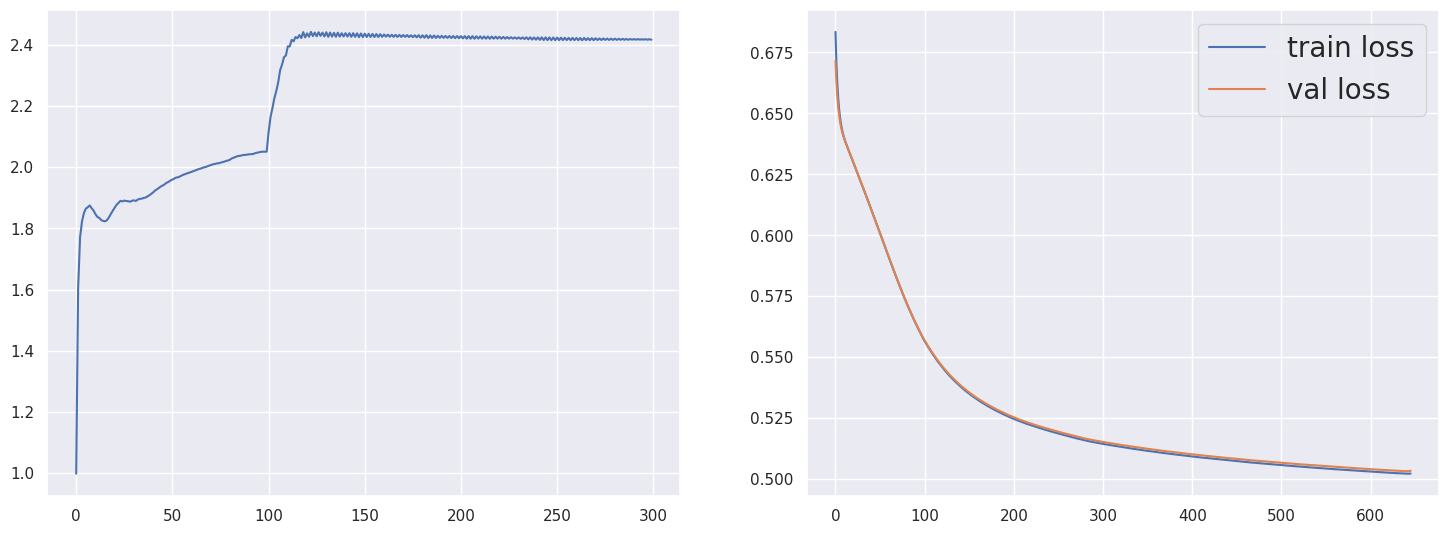

4
Behavior Model Final Training Loss: 0.506
End Epoch: 674


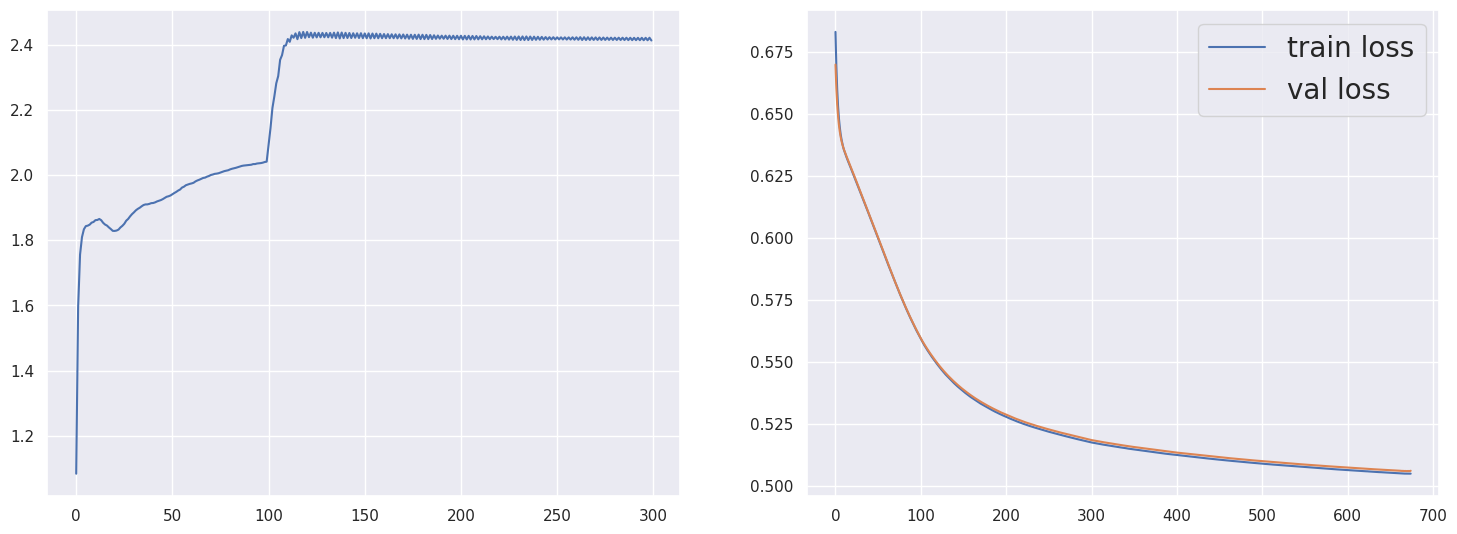

In [10]:
coarse_spg_cv_list = []


# for card_u in [8, 6, 4, 2]:
for card_u in [10, 5, 4, 3, 2]:
    print(card_u)   
    # u_coarse_vol = (true_card_u) // card_u # ceiling
    u_coarse_vol = (true_card_u + card_u - 1) // card_u # ceiling

    spg_cv = []
    init_seed = 0


    for rep_index in range(5):
        spg_curve = StrategicGD_coarse(cost_coef=cost_coef, f=10000, lr_pi=0.05, lr_prob=0.1, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                

        coarse_spg_cv_list.append(spg_curve)    

In [11]:
torch.save(coarse_spg_cv_list, "coarse_spg_cv_list_true_2-10card{}_rep5.pkl".format(true_card_u))

In [17]:
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda")
torch.manual_seed(1)
dim_v = 20

true_card_u = 10

# coarse_spg_cv_list = []

beta = torch.tensor(list(np.linspace(-5, 5, true_card_u)) + list(np.random.normal(0, 1, size = (dim_v,))), dtype=torch.float32).view(-1, 1)

trans = torch.rand((dim_v, true_card_u), dtype=torch.float32)

H = 100
len_seq = 100
num_epoch = 800

T = 300
n = 4000
n_eval = 10000
repeat_num = 5

cost_coef = 0.05

epoch = list(range(T)) * 10

# fix samples for policy eval 
u_eval, v_eval = x_generate(n_eval, dim_v, trans, seed=0) # fix eval


# seed_list = range(5)

seed_list = range(10)
dataset = {}
for s in seed_list:
    dataset[s] = [x_generate(n, dim_v, trans, seed=s) for i in range(T)]

10
0
Behavior Model Final Training Loss: 1.737
End Epoch: 799


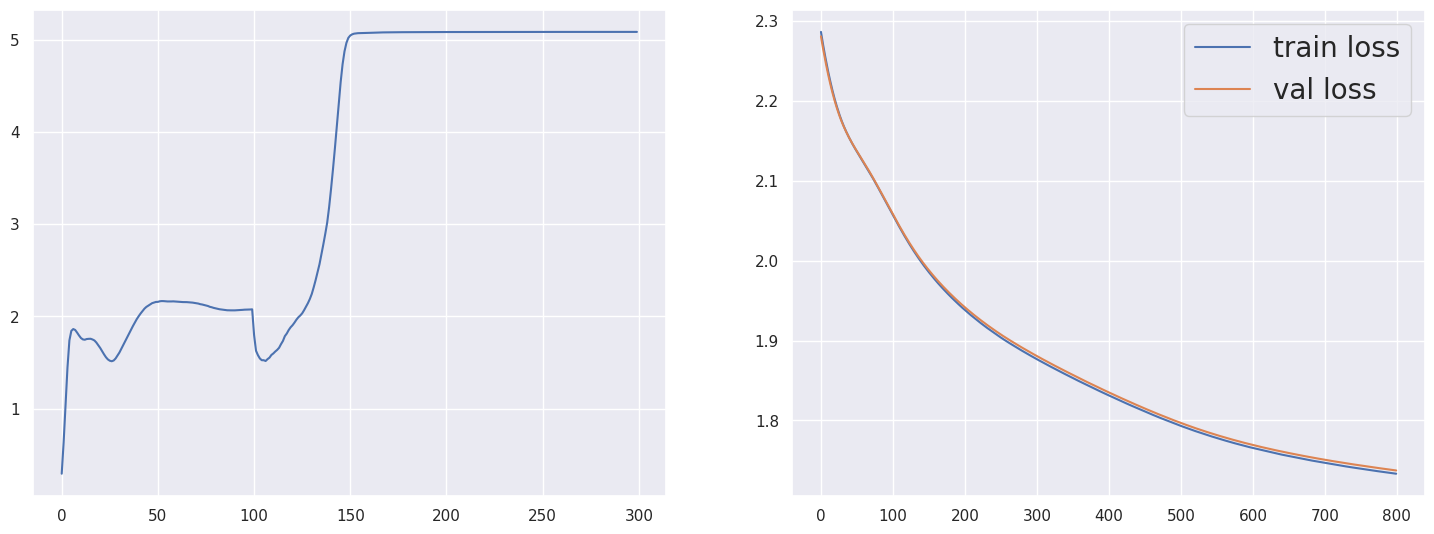

1
Behavior Model Final Training Loss: 1.683
End Epoch: 799


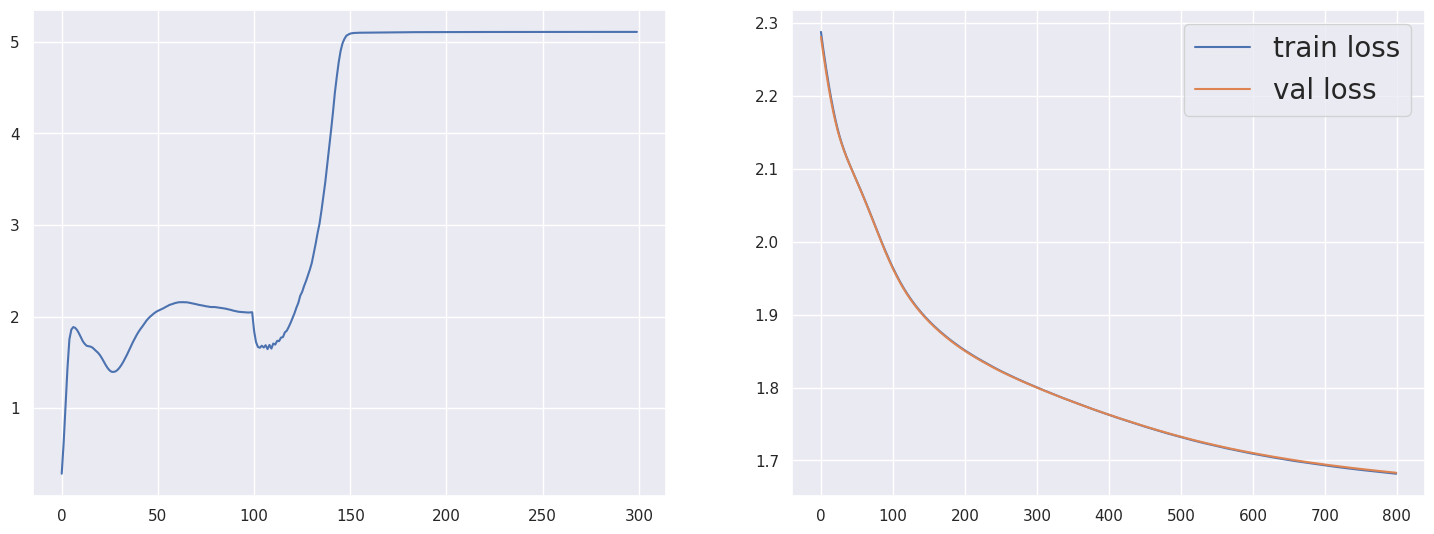

2
Behavior Model Final Training Loss: 1.682
End Epoch: 799


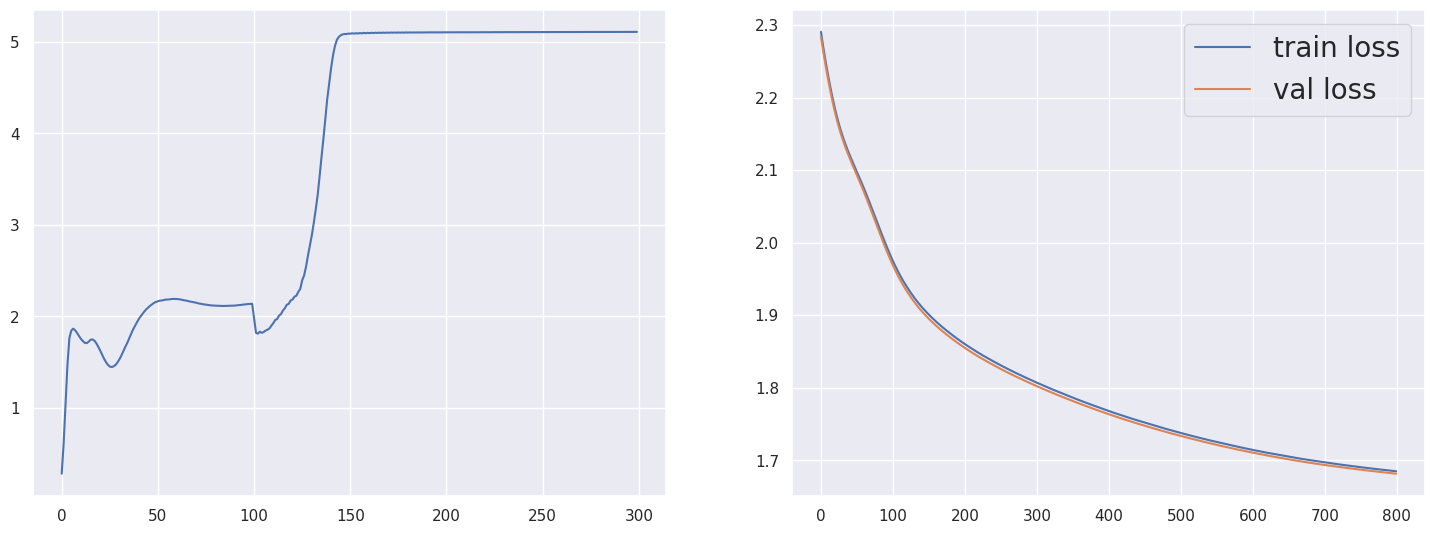

3
Behavior Model Final Training Loss: 1.728
End Epoch: 799


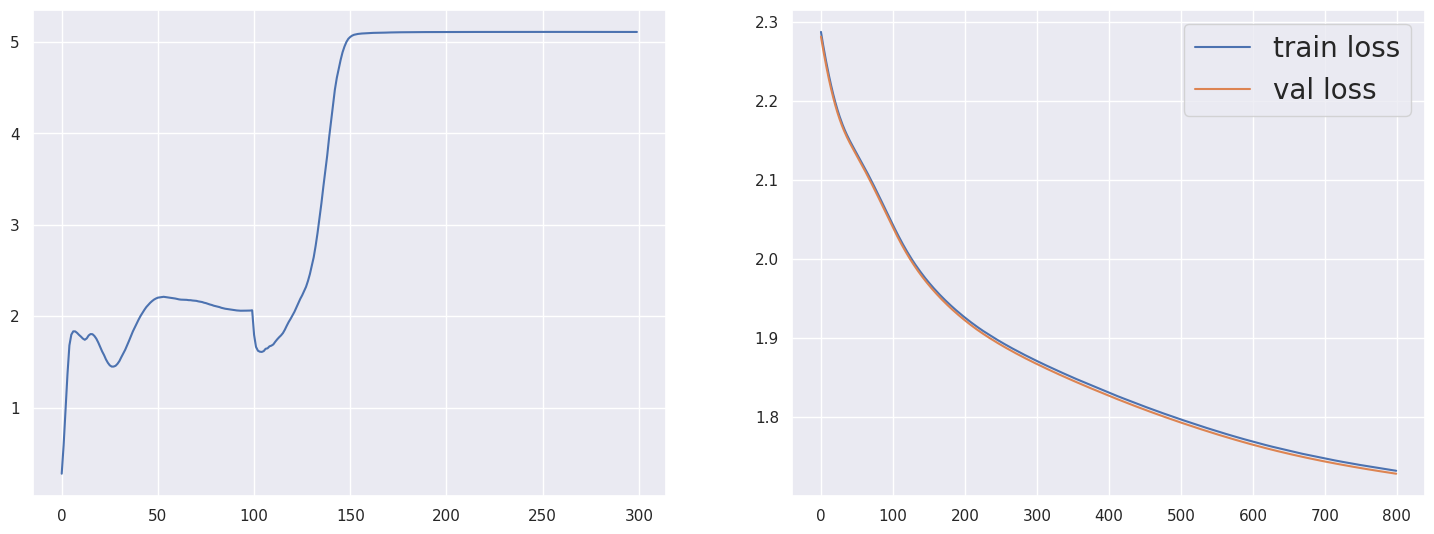

4
Behavior Model Final Training Loss: 1.732
End Epoch: 799


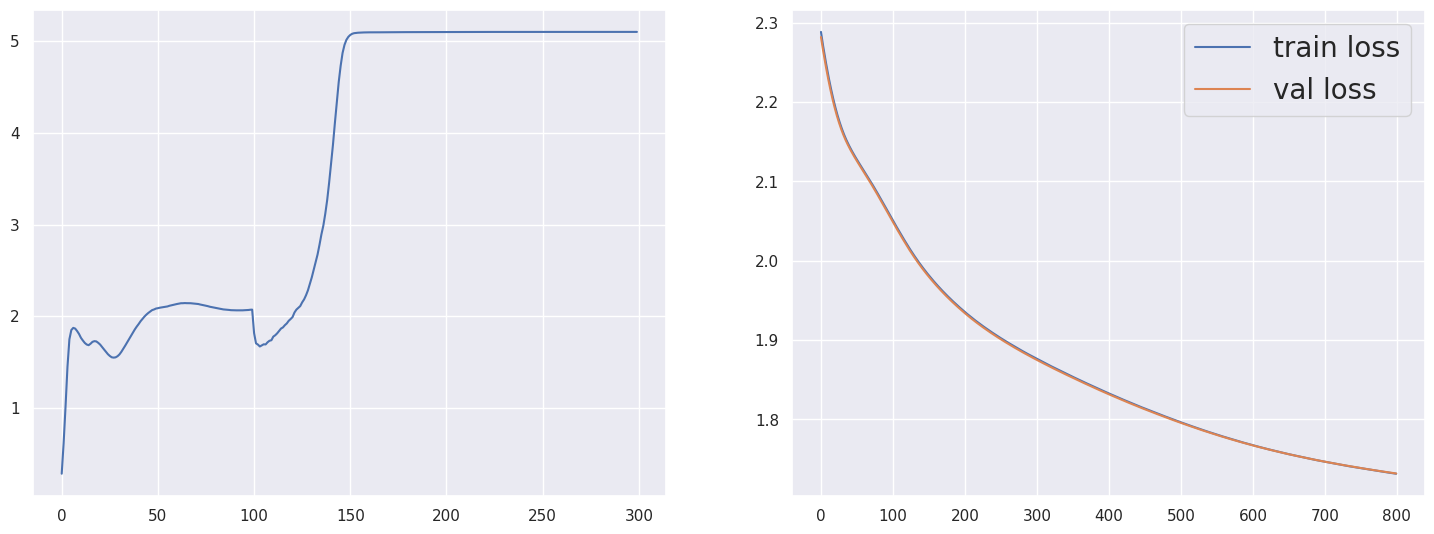

5
0
Behavior Model Final Training Loss: 1.164
End Epoch: 799


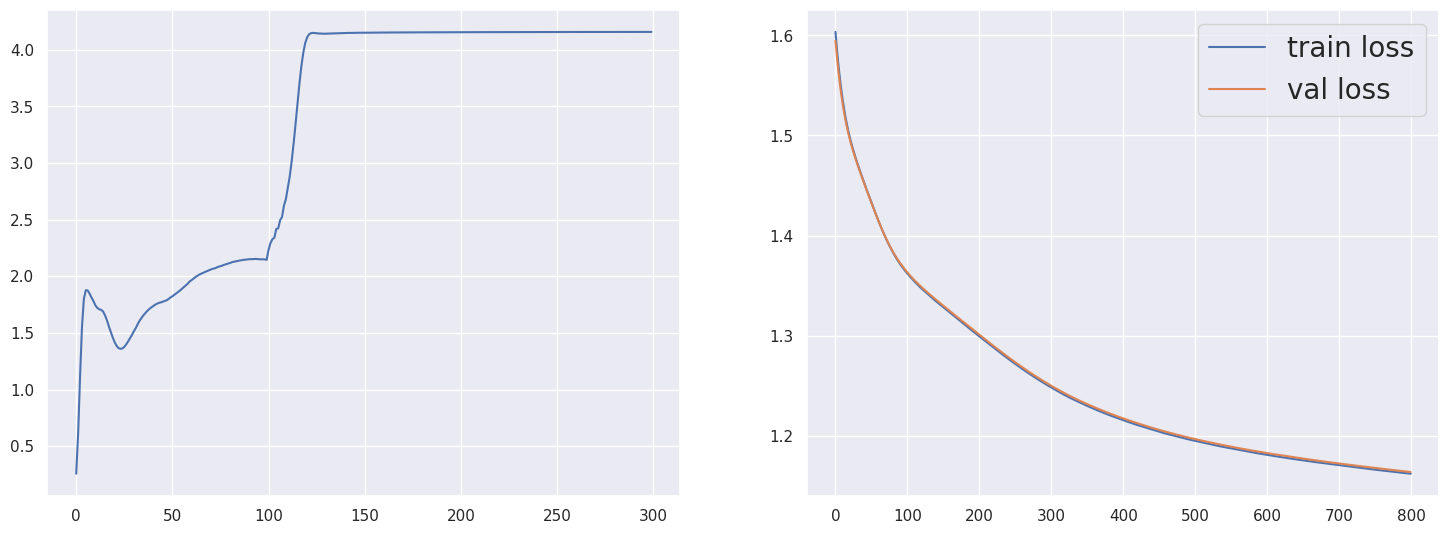

1
Behavior Model Final Training Loss: 1.154
End Epoch: 799


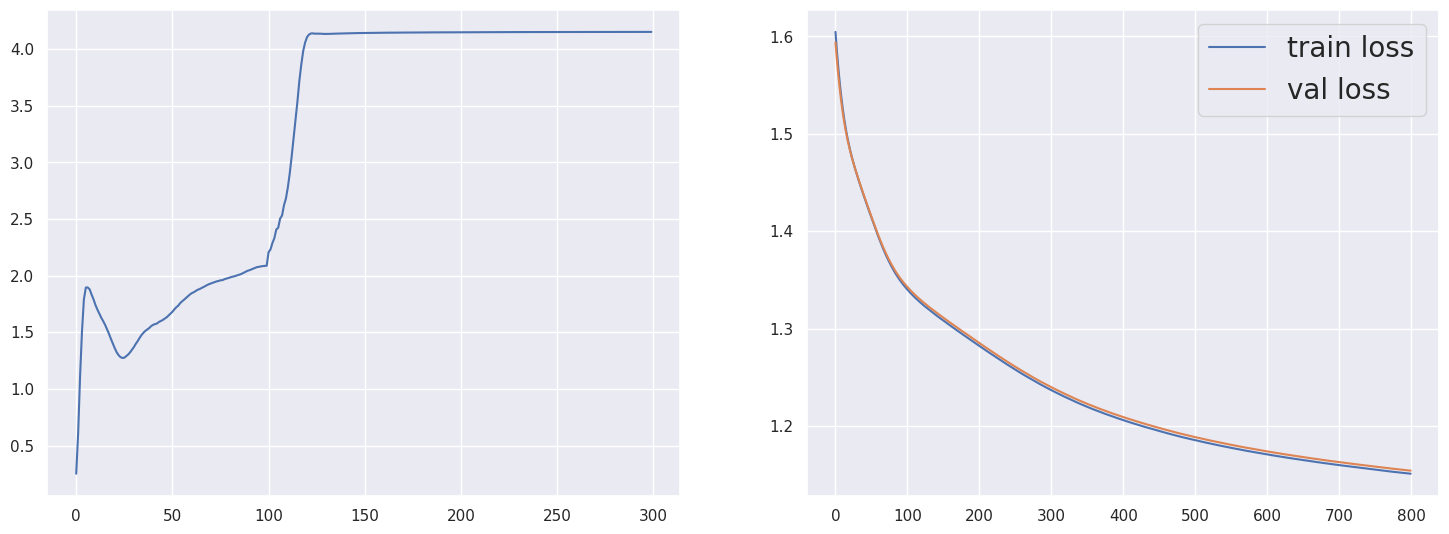

2
Behavior Model Final Training Loss: 1.150
End Epoch: 799


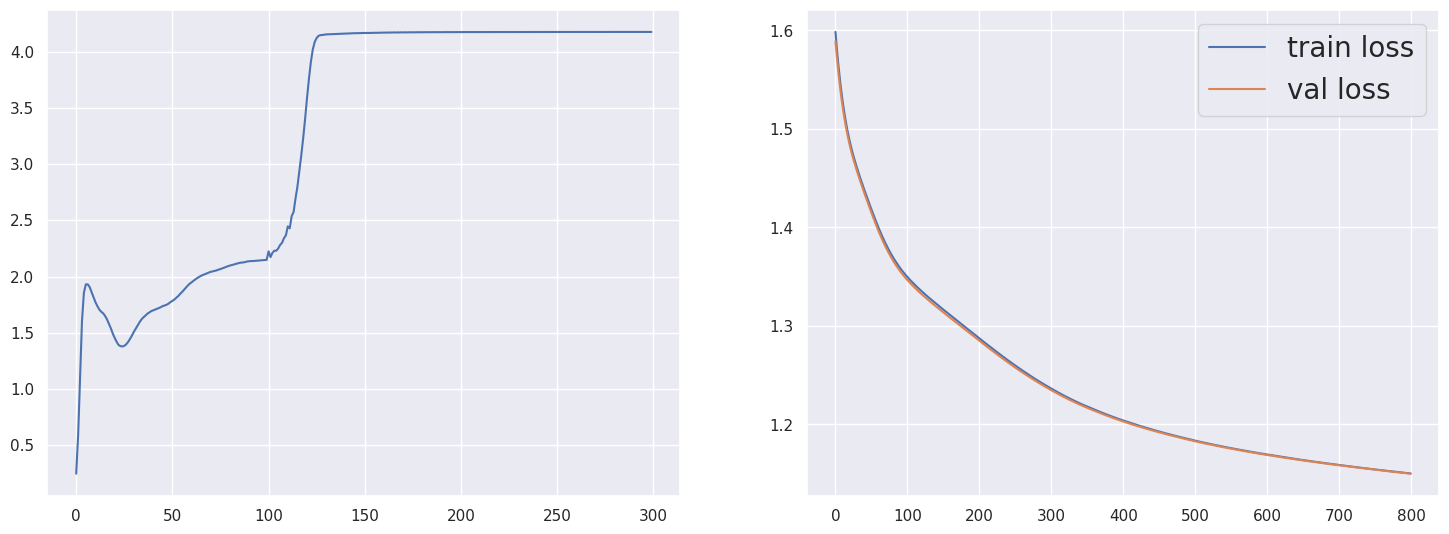

3
Behavior Model Final Training Loss: 1.156
End Epoch: 799


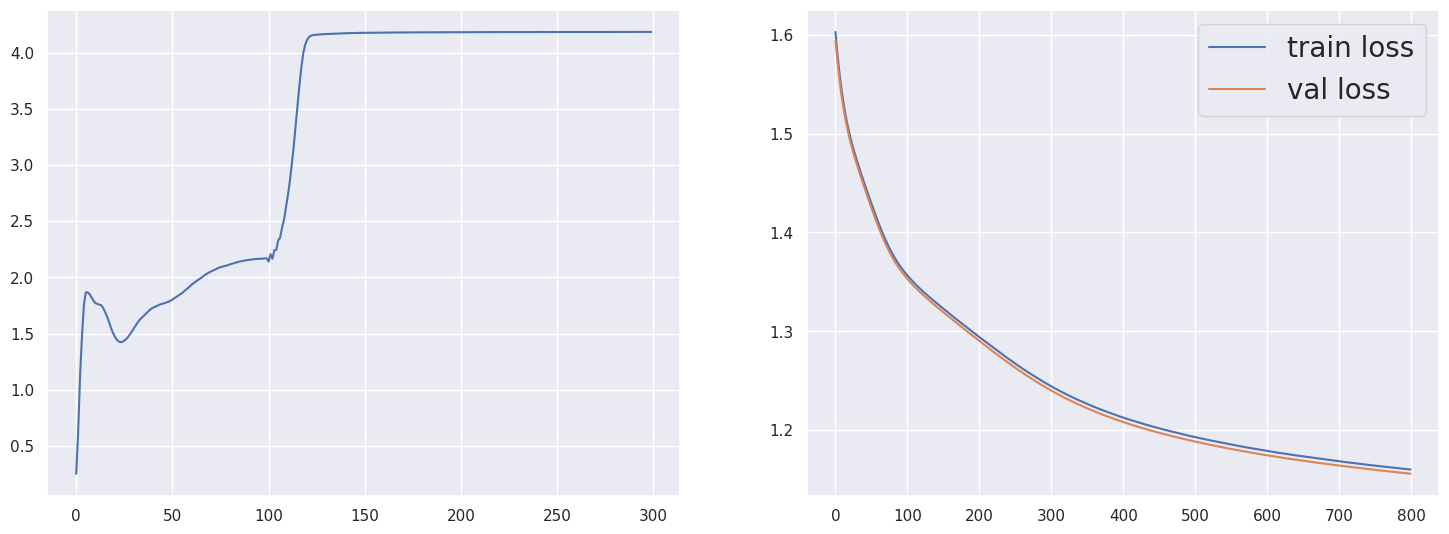

4
Behavior Model Final Training Loss: 1.142
End Epoch: 799


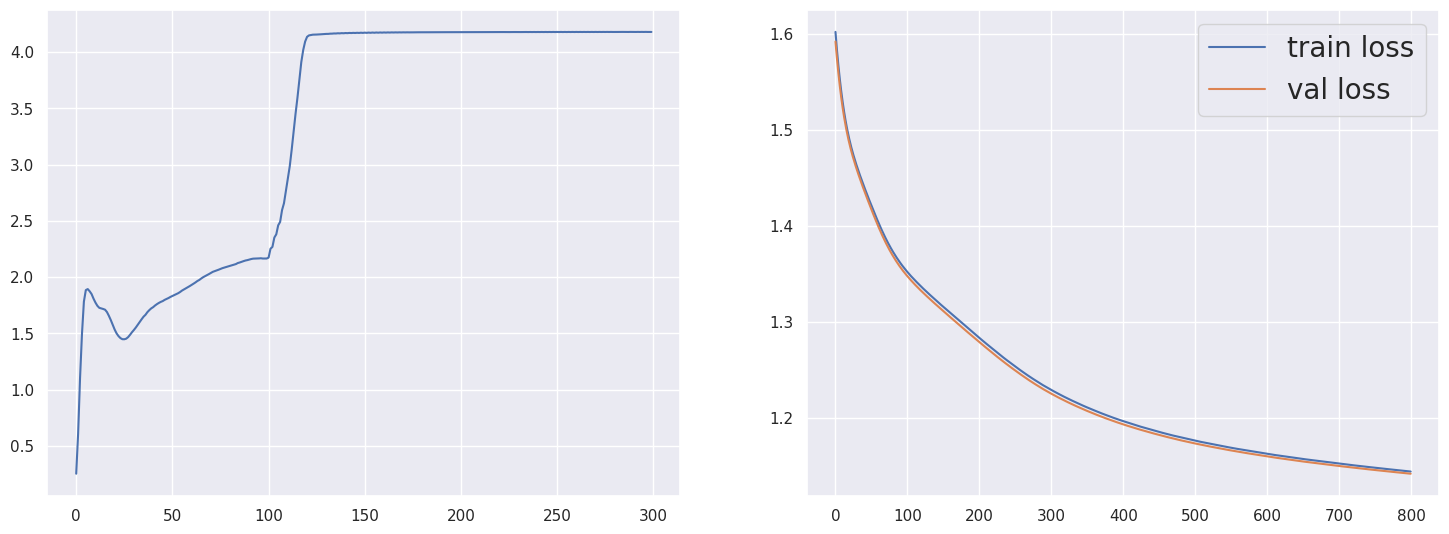

4
0
Behavior Model Final Training Loss: 0.910
End Epoch: 791


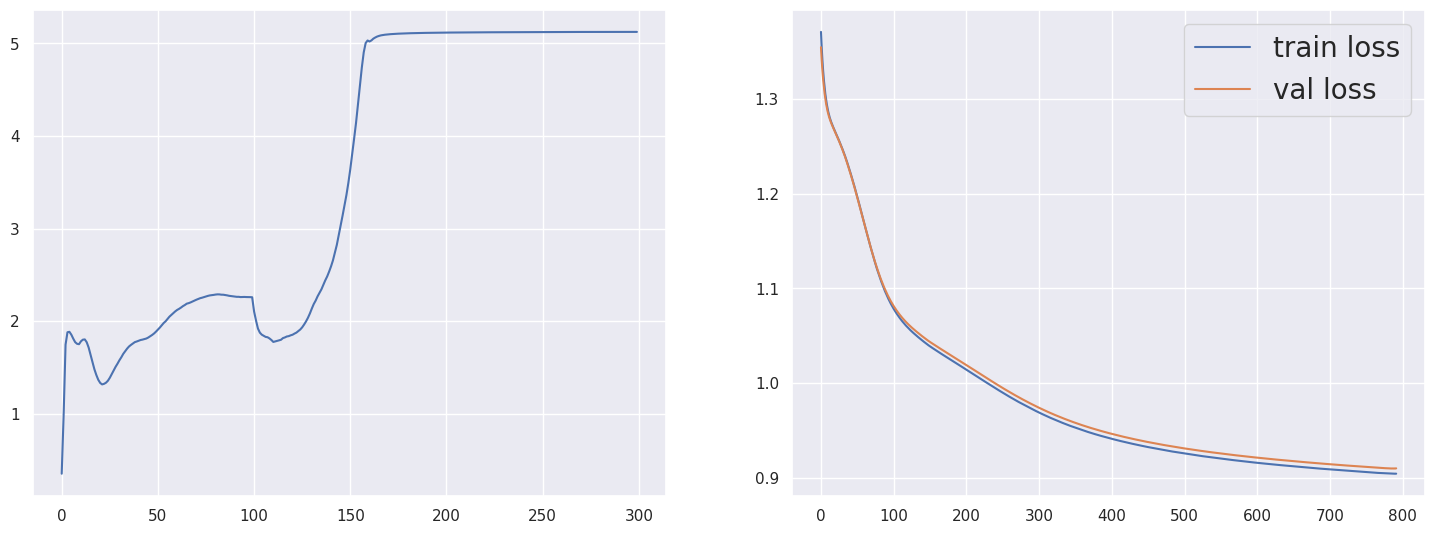

1
Behavior Model Final Training Loss: 0.925
End Epoch: 686


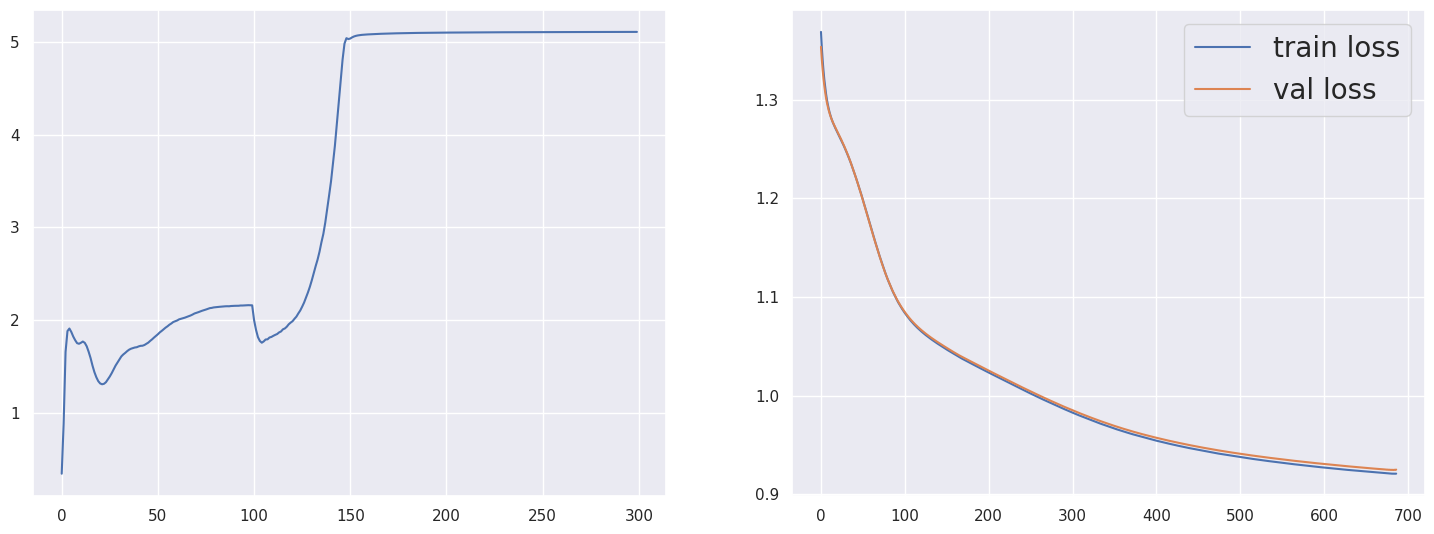

2
Behavior Model Final Training Loss: 0.913
End Epoch: 799


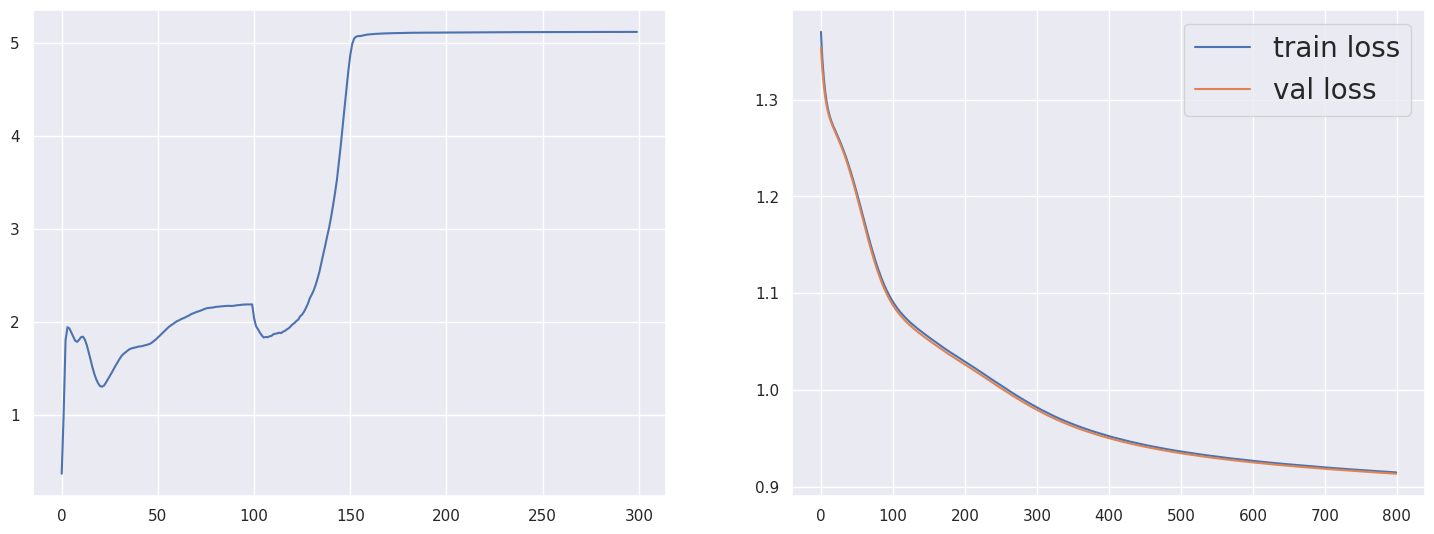

3
Behavior Model Final Training Loss: 0.936
End Epoch: 641


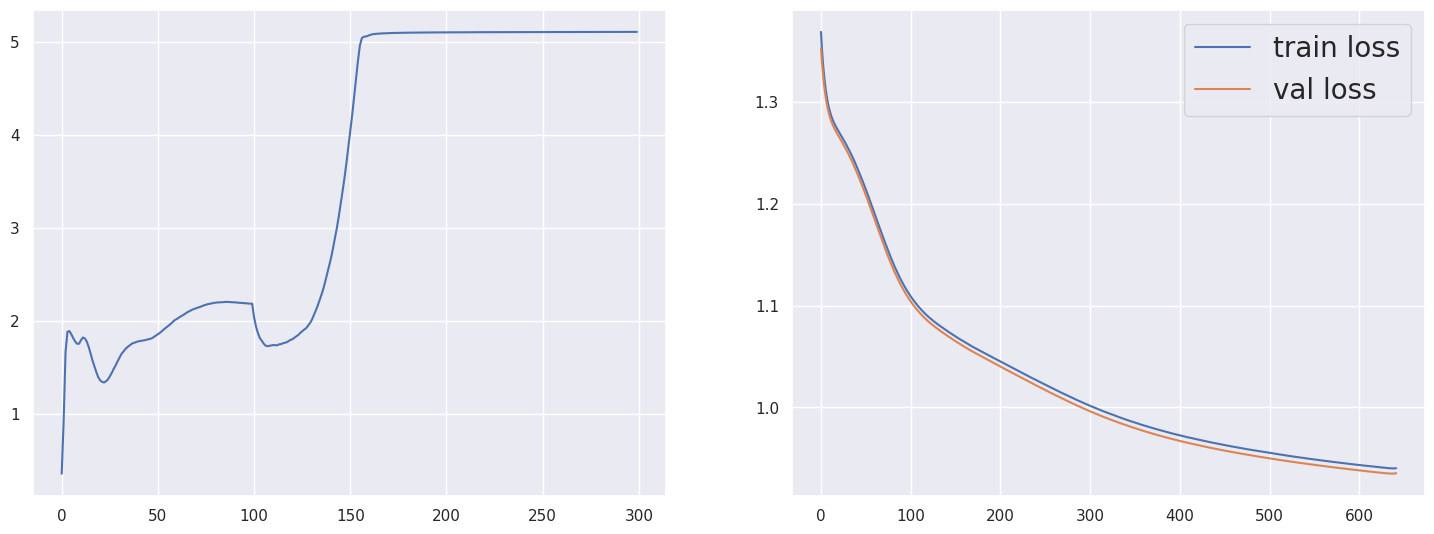

4
Behavior Model Final Training Loss: 0.906
End Epoch: 799


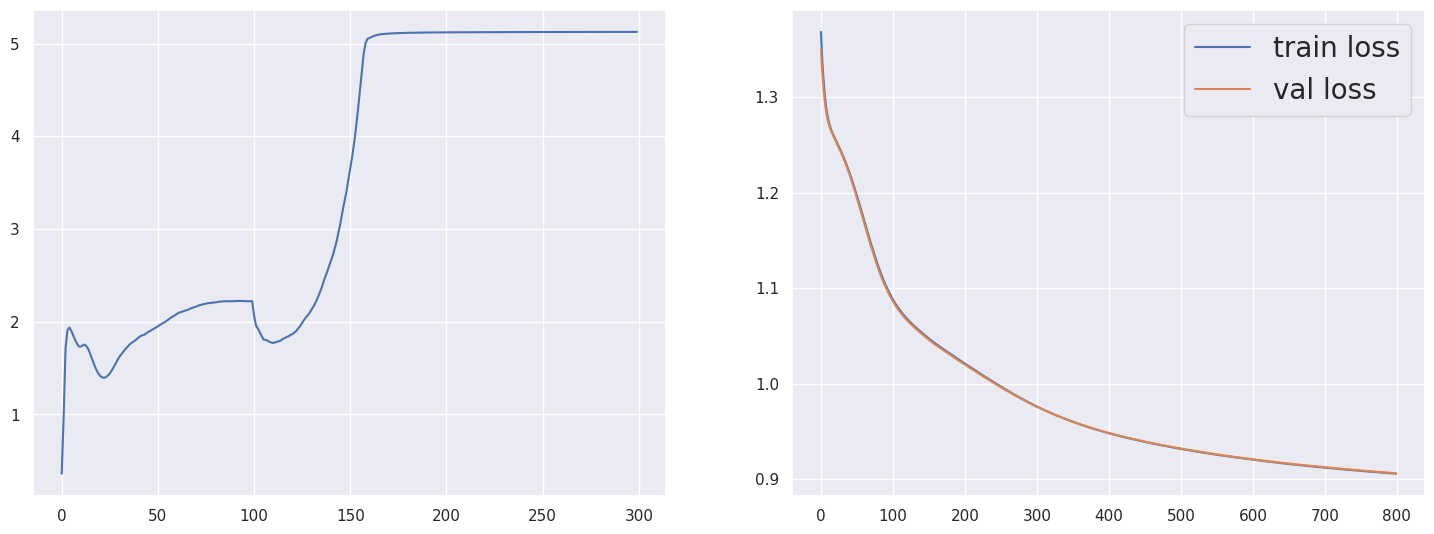

3
0
Behavior Model Final Training Loss: 0.760
End Epoch: 666


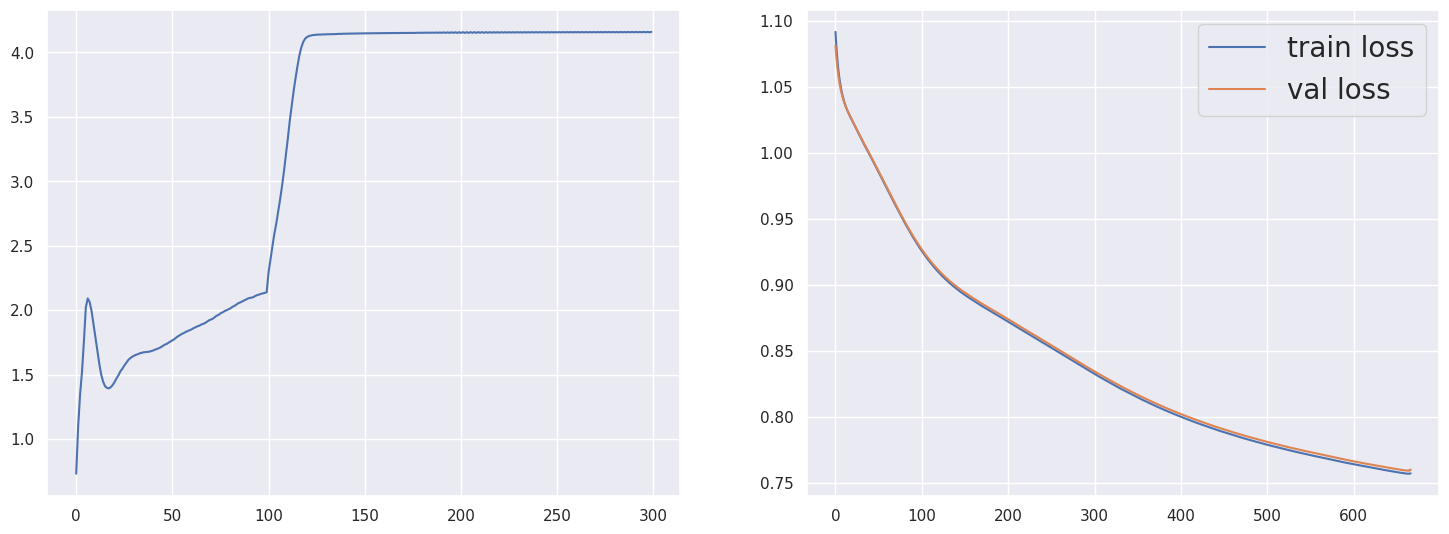

1
Behavior Model Final Training Loss: 0.749
End Epoch: 643


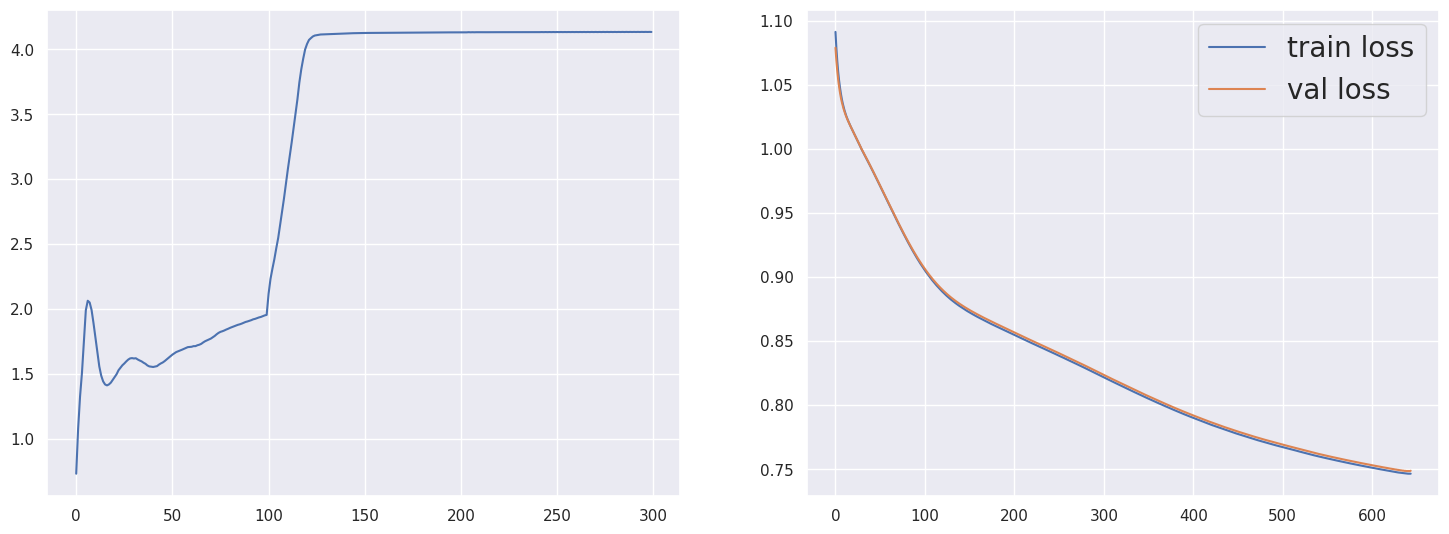

2
Behavior Model Final Training Loss: 0.745
End Epoch: 636


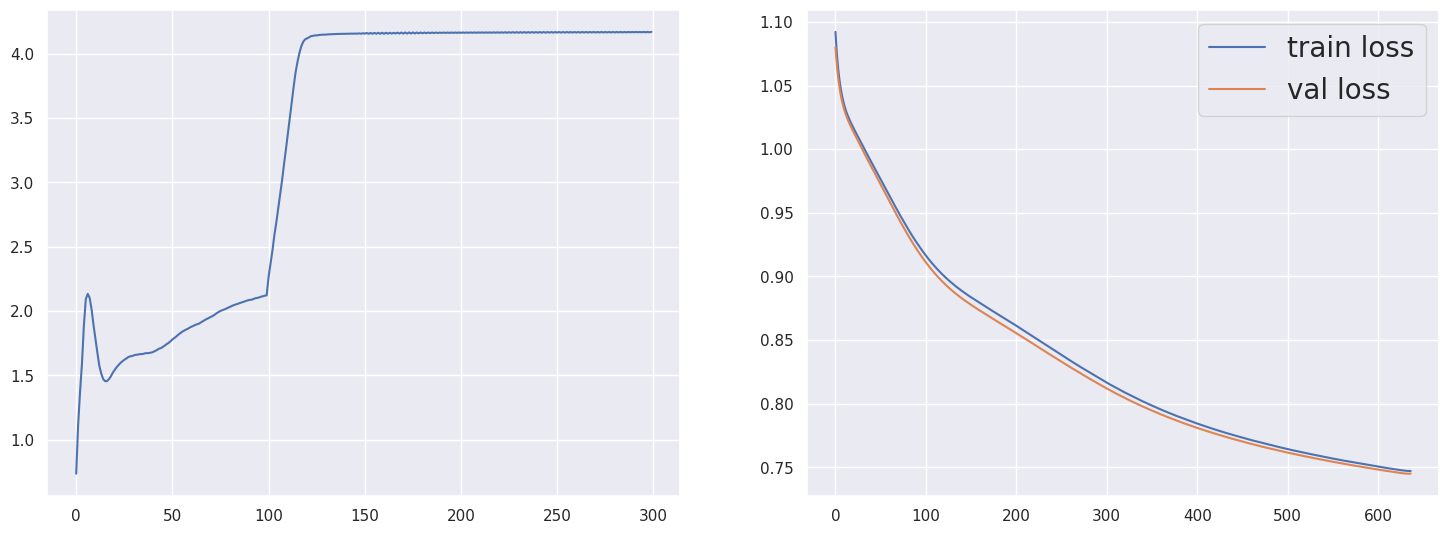

3
Behavior Model Final Training Loss: 0.744
End Epoch: 629


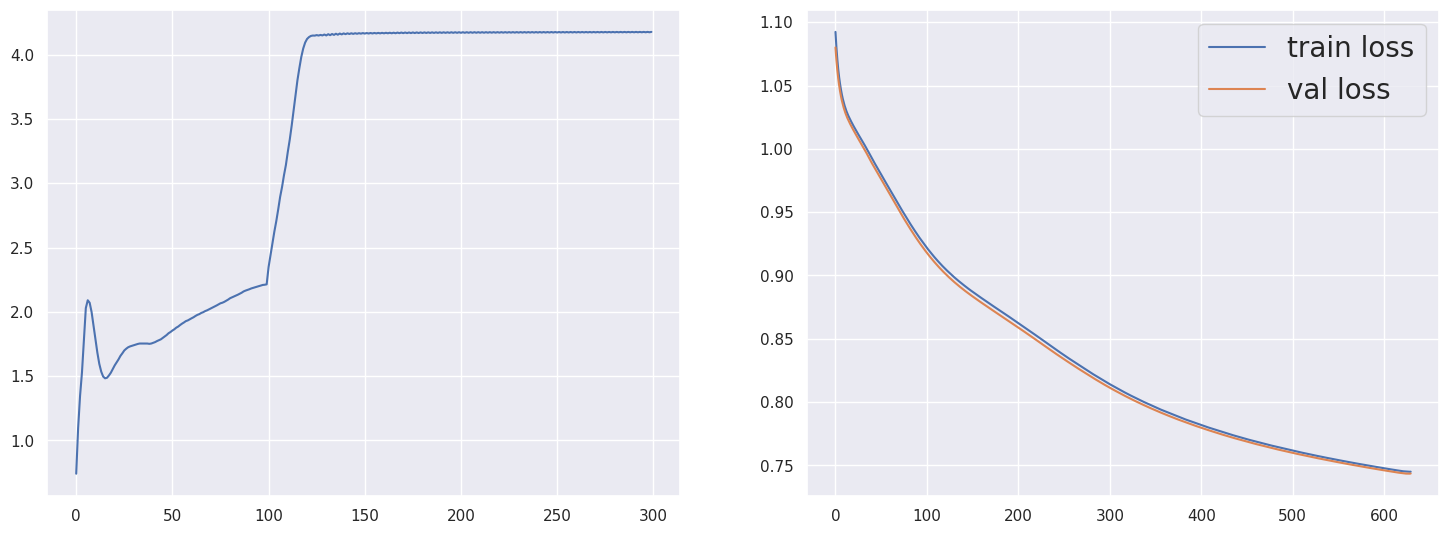

4
Behavior Model Final Training Loss: 0.750
End Epoch: 634


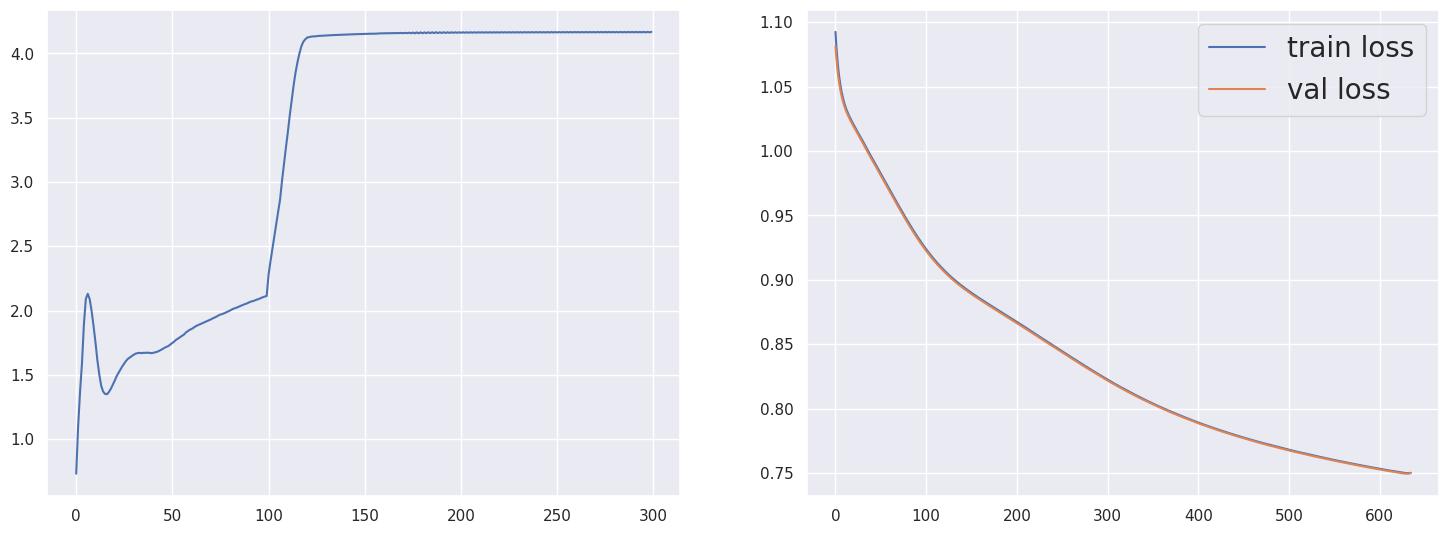

2
0
Behavior Model Final Training Loss: 0.466
End Epoch: 457


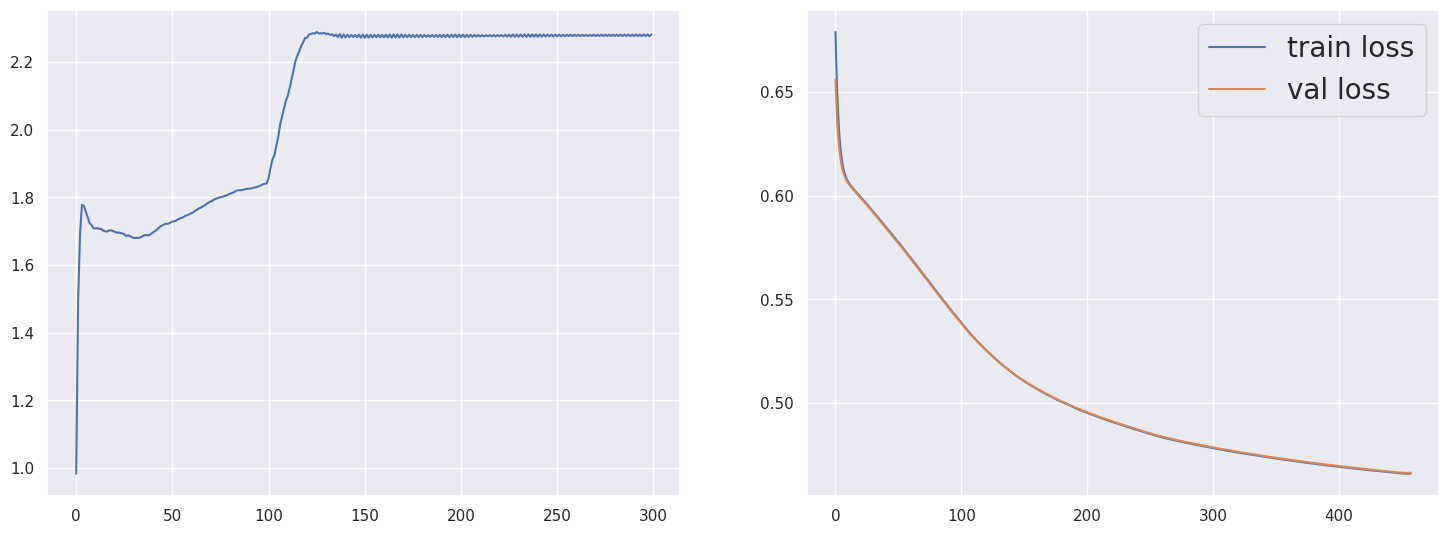

1


In [ ]:
coarse_spg_cv_list2 = []


# for card_u in [8, 6, 4, 2]:
for card_u in [10, 5, 4, 3, 2]:
    print(card_u)   
    # u_coarse_vol = (true_card_u) // card_u # ceiling
    u_coarse_vol = (true_card_u + card_u - 1) // card_u # ceiling

    spg_cv = []
    init_seed = 0


    for rep_index in range(5):
        spg_curve = StrategicGD_coarse(cost_coef=cost_coef, f=10000, lr_pi=0.03, lr_prob=0.1, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                

        coarse_spg_cv_list2.append(spg_curve)    

In [ ]:
torch.save(coarse_spg_cv_list2, "coarse_spg_cv_list_true_2-10card{}_rep5.pkl".format(true_card_u))

In [5]:
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda")
torch.manual_seed(1)
dim_v = 20

true_card_u = 15

# coarse_spg_cv_list = []

beta = torch.tensor(list(np.linspace(-5, 5, true_card_u)) + list(np.random.normal(0, 1, size = (dim_v,))), dtype=torch.float32).view(-1, 1)

trans = torch.rand((dim_v, true_card_u), dtype=torch.float32)

H = 100
len_seq = 100
num_epoch = 800

T = 300
n = 4000
n_eval = 10000
repeat_num = 5

cost_coef = 0.05

epoch = list(range(T)) * 10

# fix samples for policy eval 
u_eval, v_eval = x_generate(n_eval, dim_v, trans, seed=0) # fix eval


# seed_list = range(5)

seed_list = range(10)
dataset = {}
for s in seed_list:
    dataset[s] = [x_generate(n, dim_v, trans, seed=s) for i in range(T)]

10
0
Behavior Model Final Training Loss: 1.476
End Epoch: 799


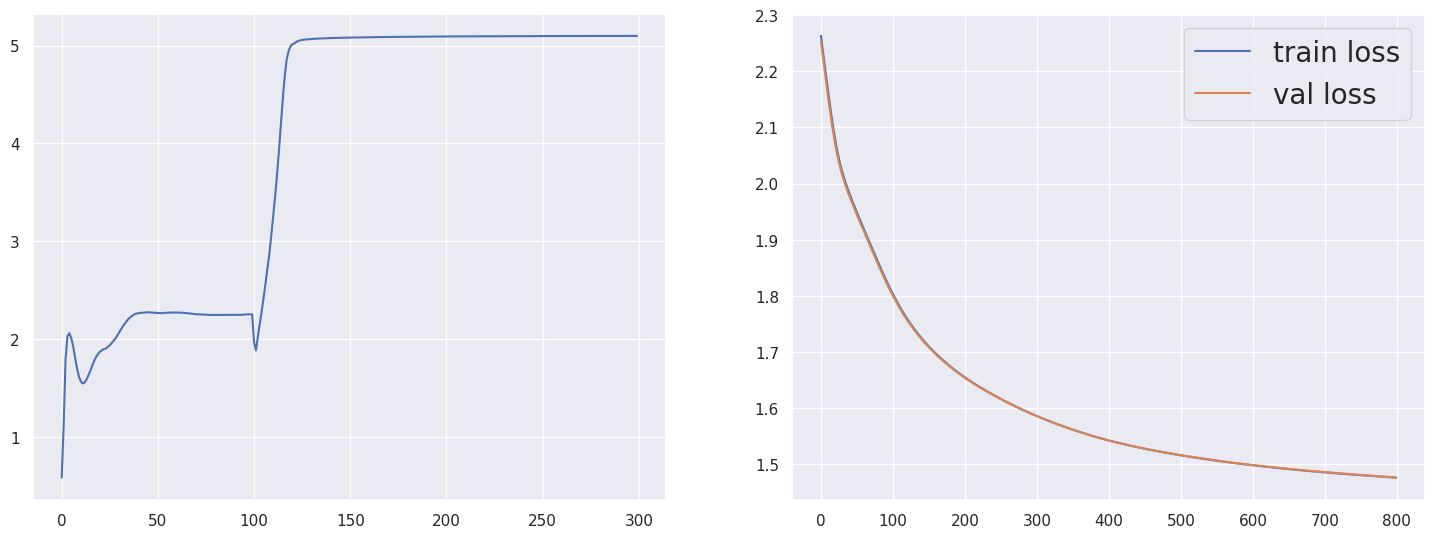

1
Behavior Model Final Training Loss: 1.493
End Epoch: 799


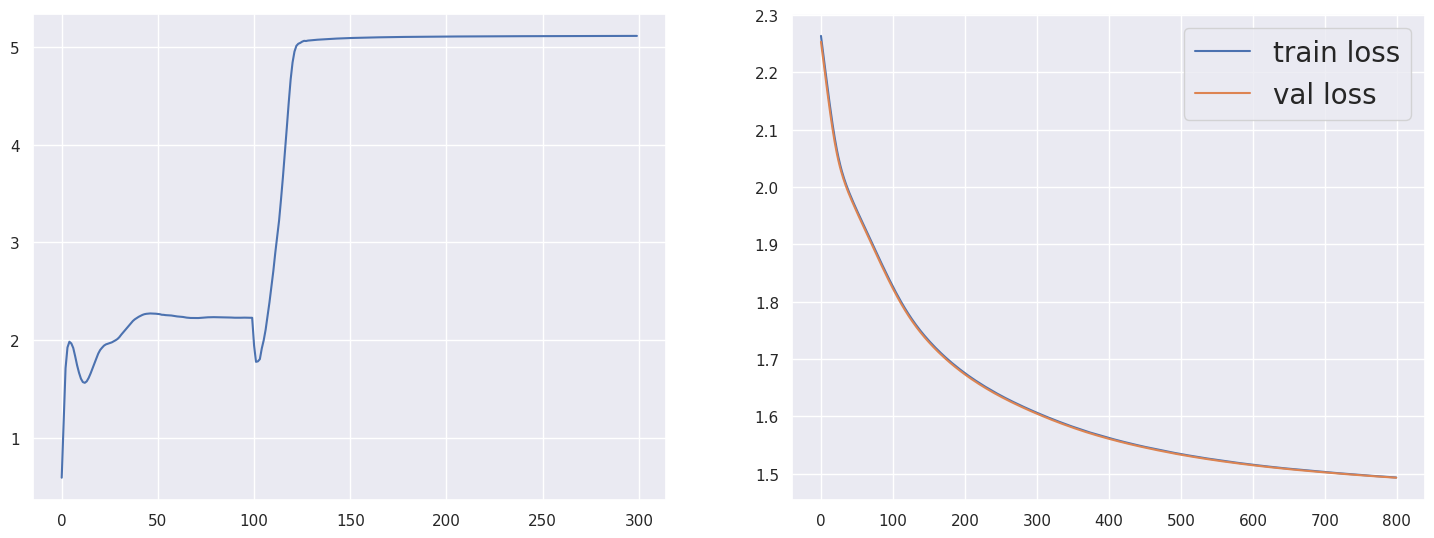

2
Behavior Model Final Training Loss: 1.459
End Epoch: 799


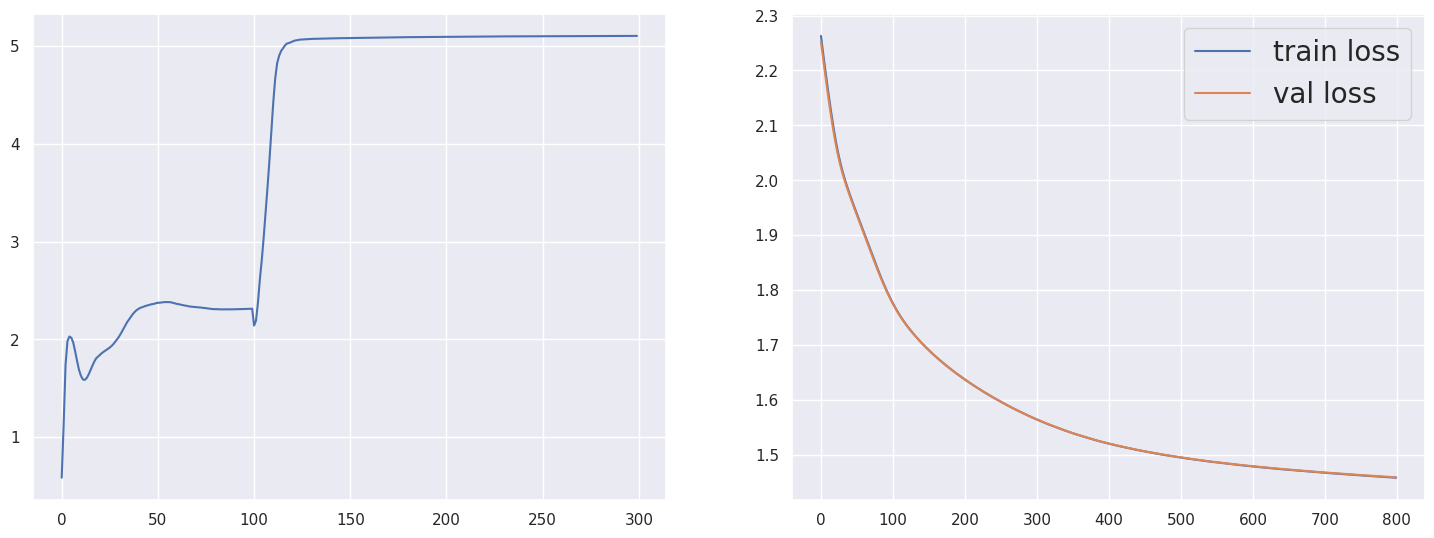

3
Behavior Model Final Training Loss: 1.480
End Epoch: 799


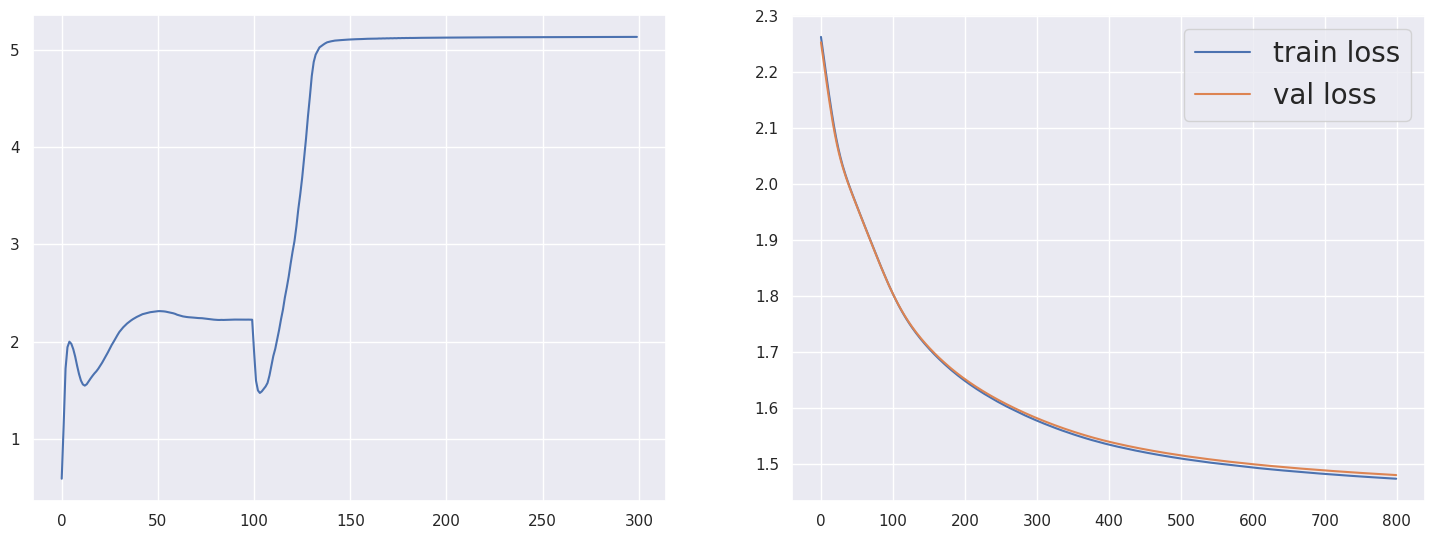

4
Behavior Model Final Training Loss: 1.507
End Epoch: 799


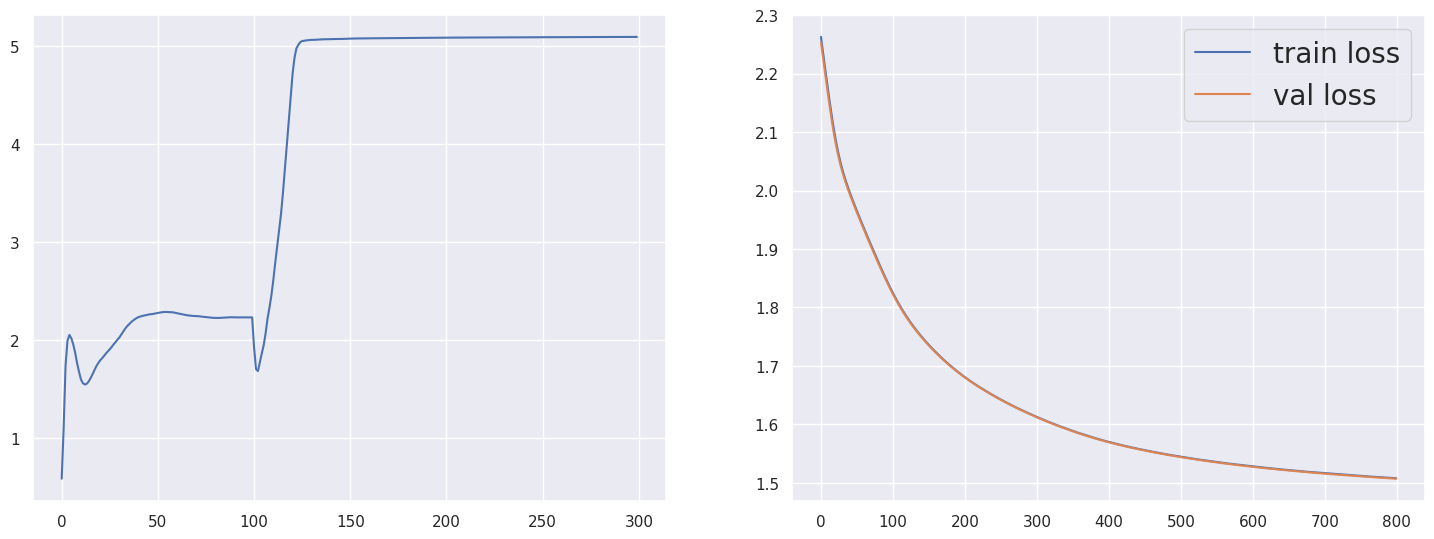

5
0
Behavior Model Final Training Loss: 1.130
End Epoch: 799


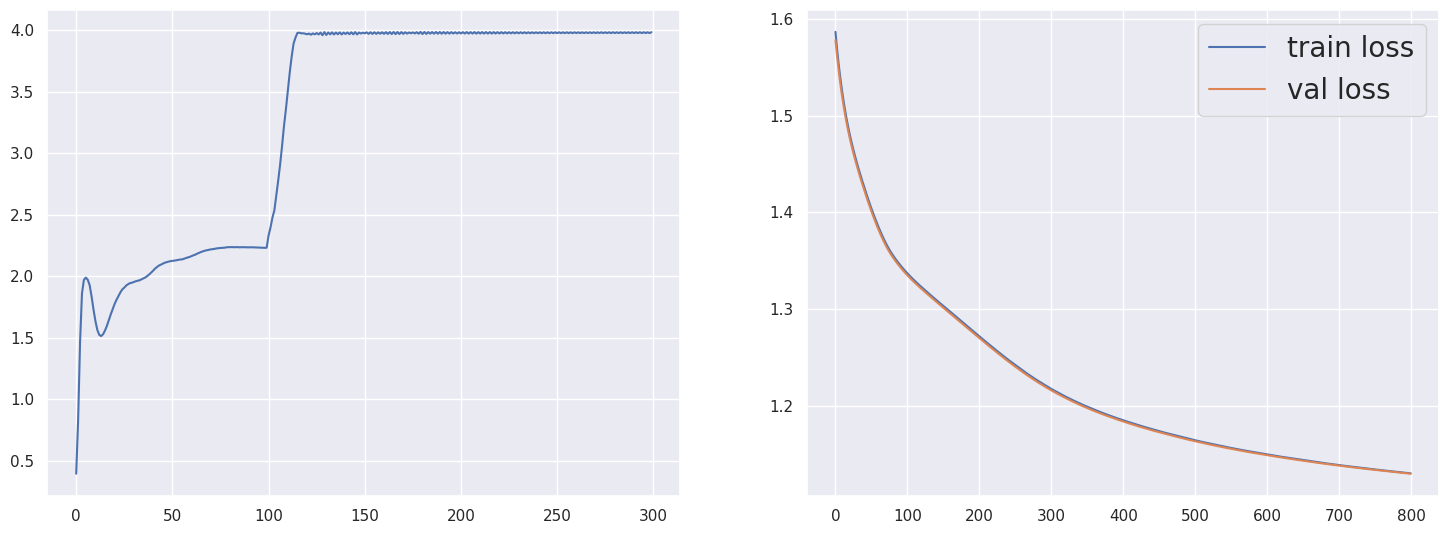

1
Behavior Model Final Training Loss: 1.165
End Epoch: 799


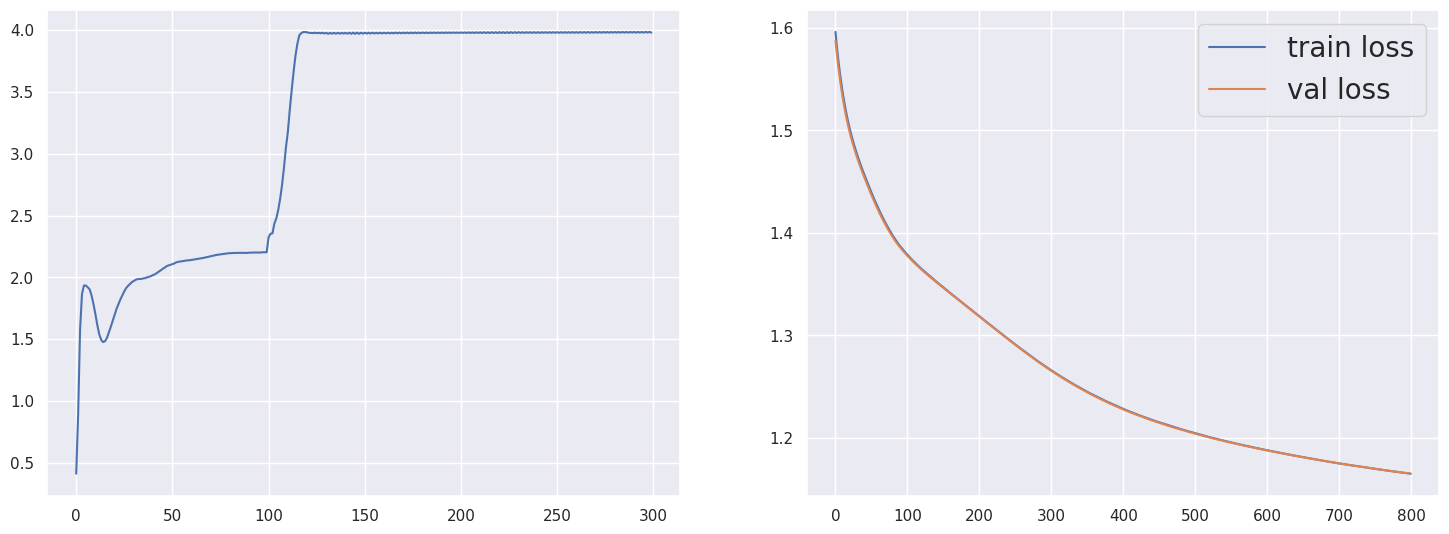

2
Behavior Model Final Training Loss: 1.139
End Epoch: 799


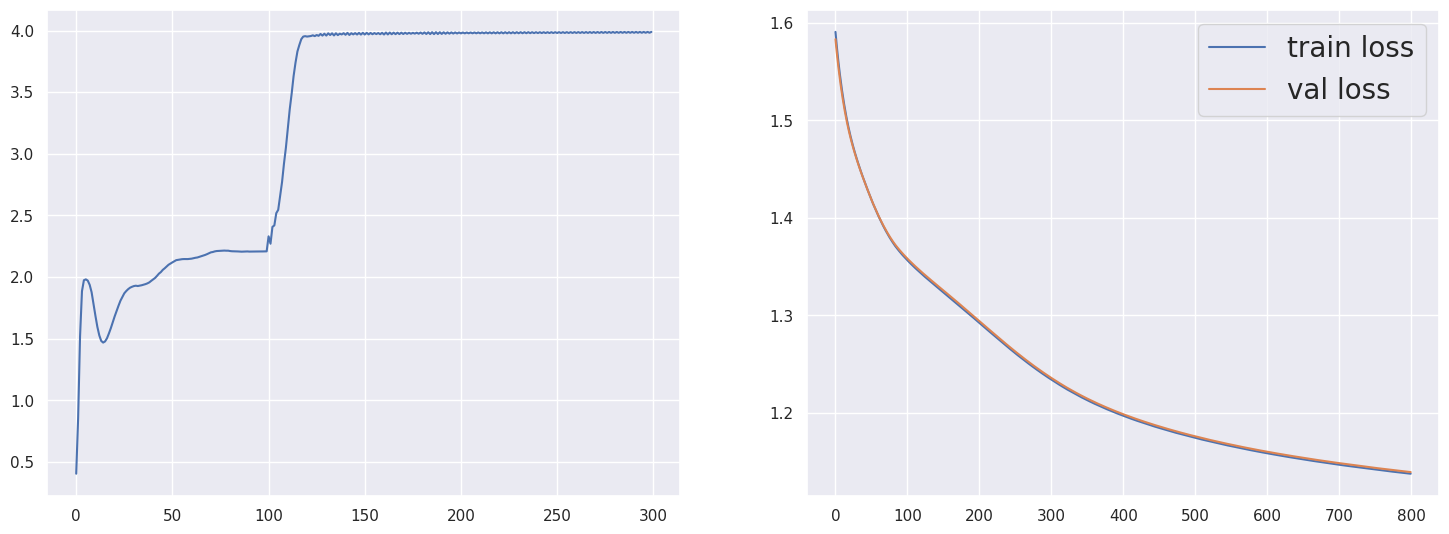

3
Behavior Model Final Training Loss: 1.157
End Epoch: 799


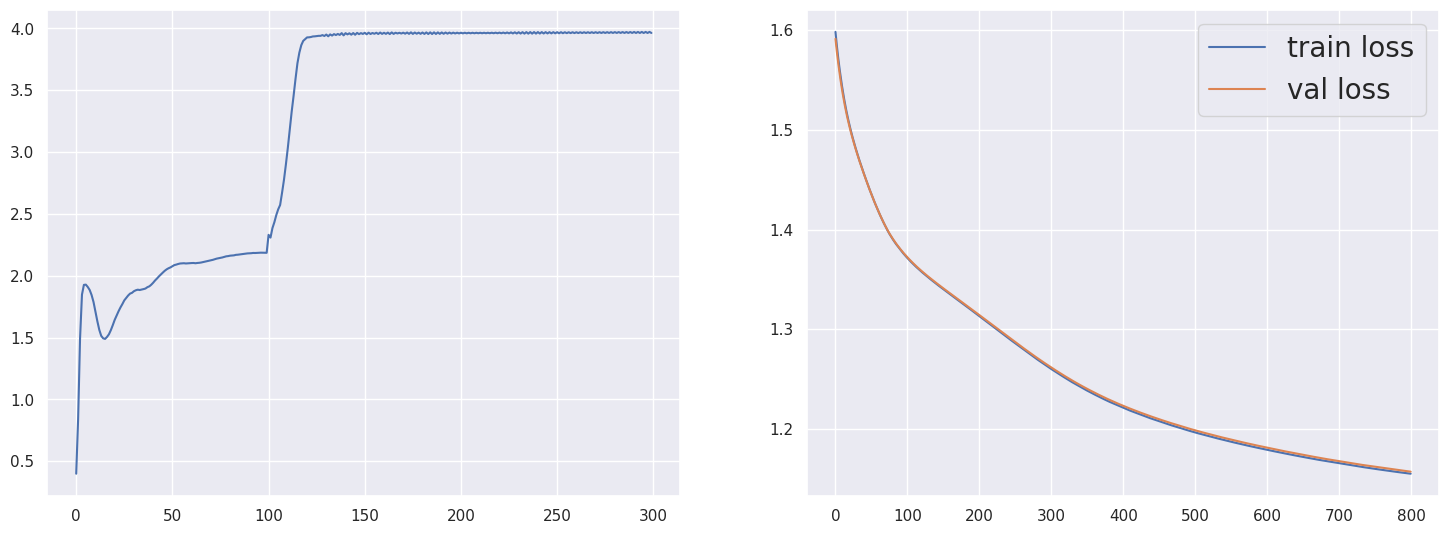

4
Behavior Model Final Training Loss: 1.160
End Epoch: 799


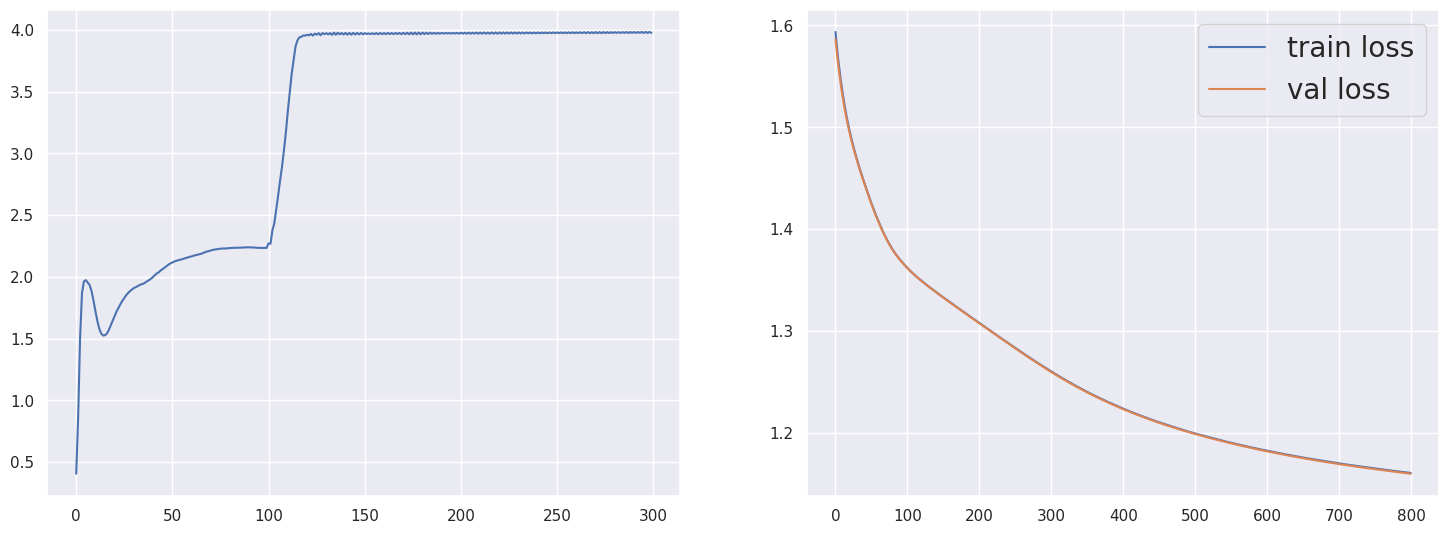

4
0
Behavior Model Final Training Loss: 0.950
End Epoch: 799


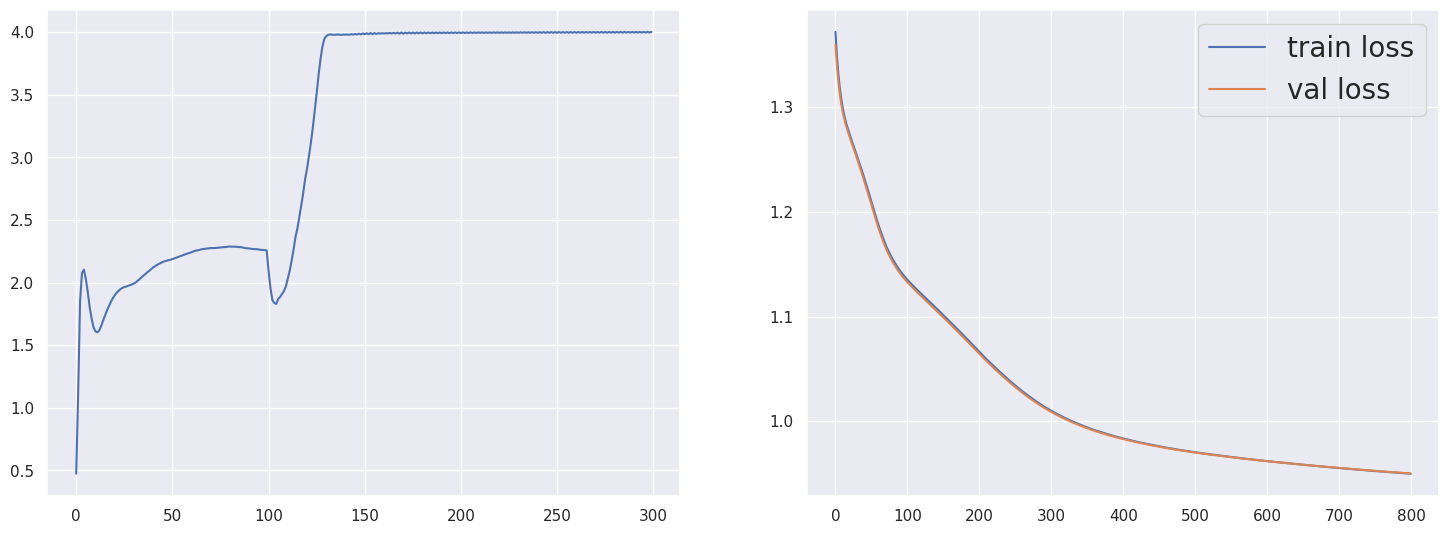

1
Behavior Model Final Training Loss: 0.962
End Epoch: 799


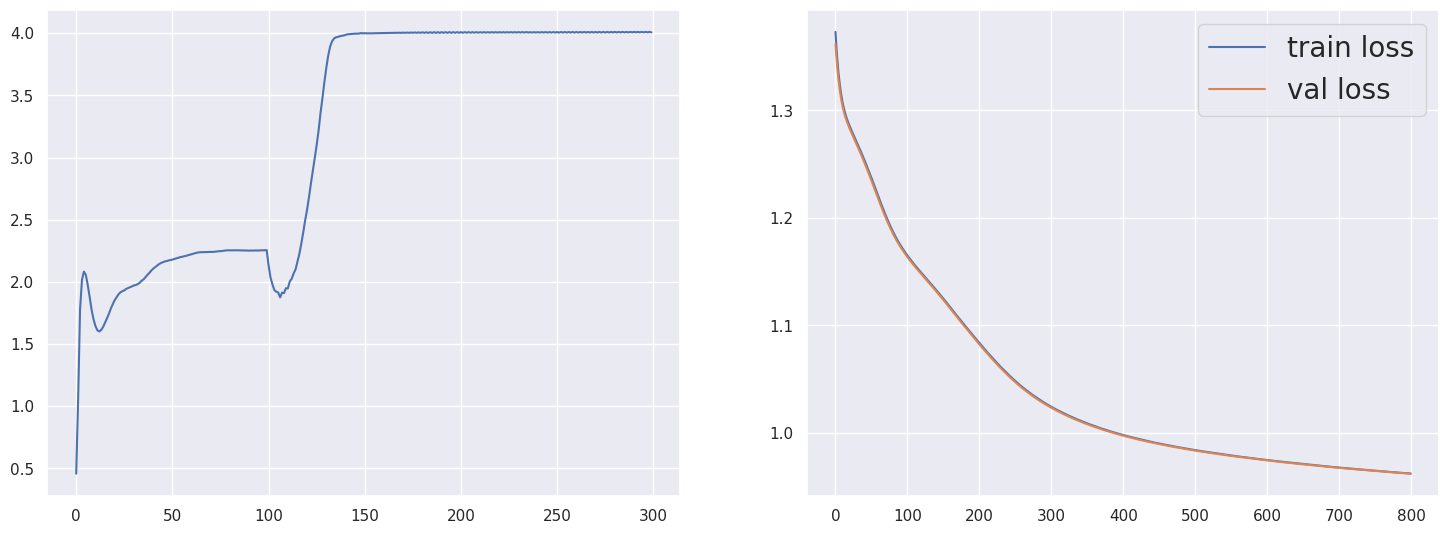

2
Behavior Model Final Training Loss: 0.969
End Epoch: 799


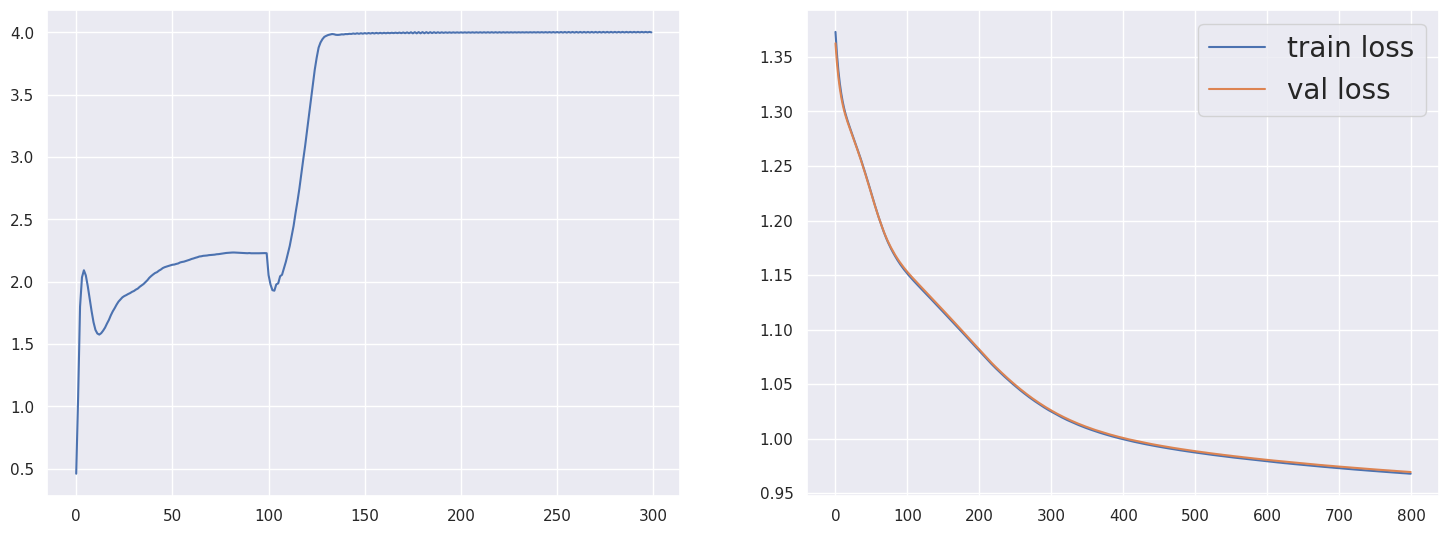

3
Behavior Model Final Training Loss: 0.950
End Epoch: 799


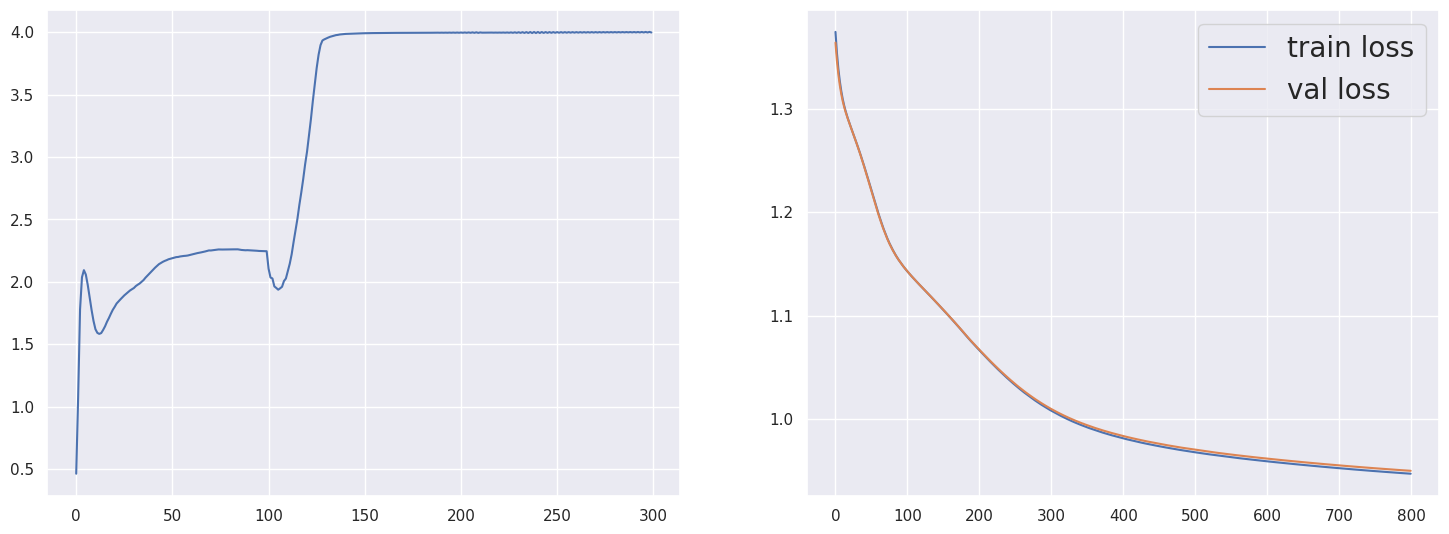

4
Behavior Model Final Training Loss: 0.989
End Epoch: 799


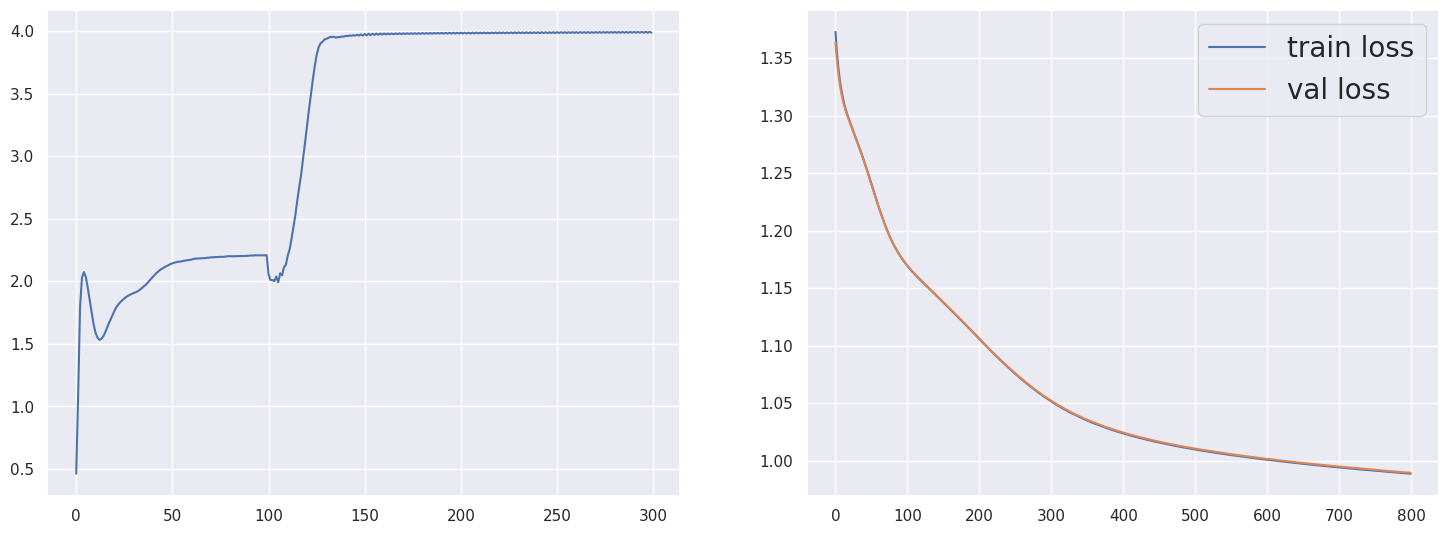

3
0
Behavior Model Final Training Loss: 0.749
End Epoch: 587


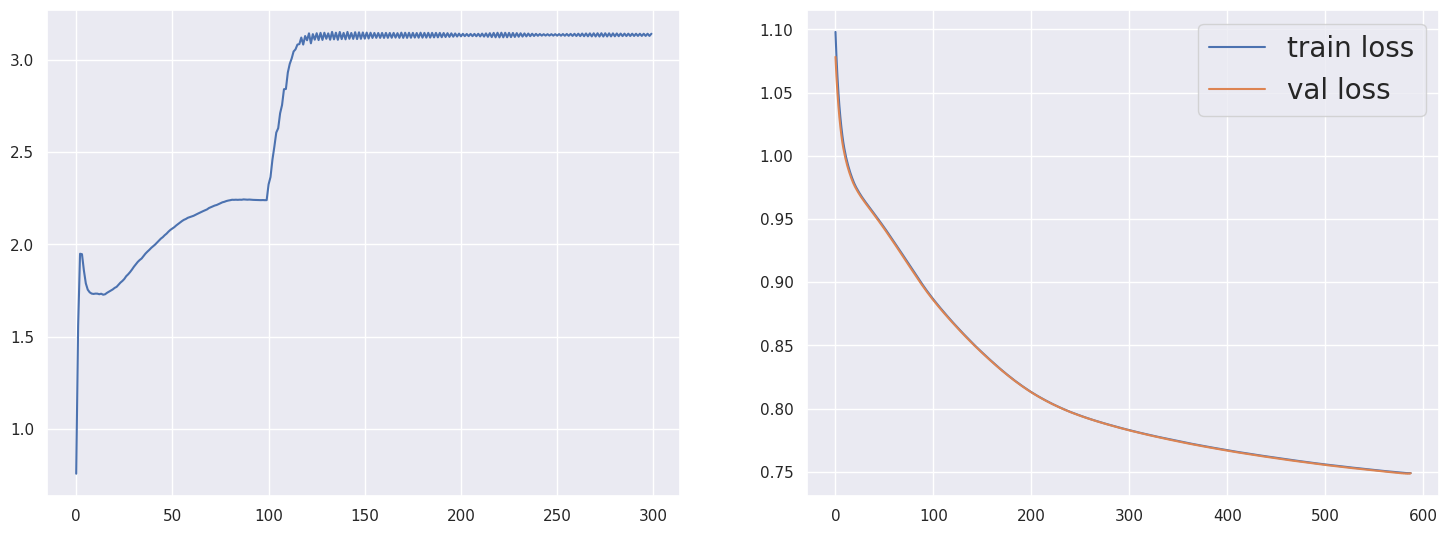

1
Behavior Model Final Training Loss: 0.764
End Epoch: 558


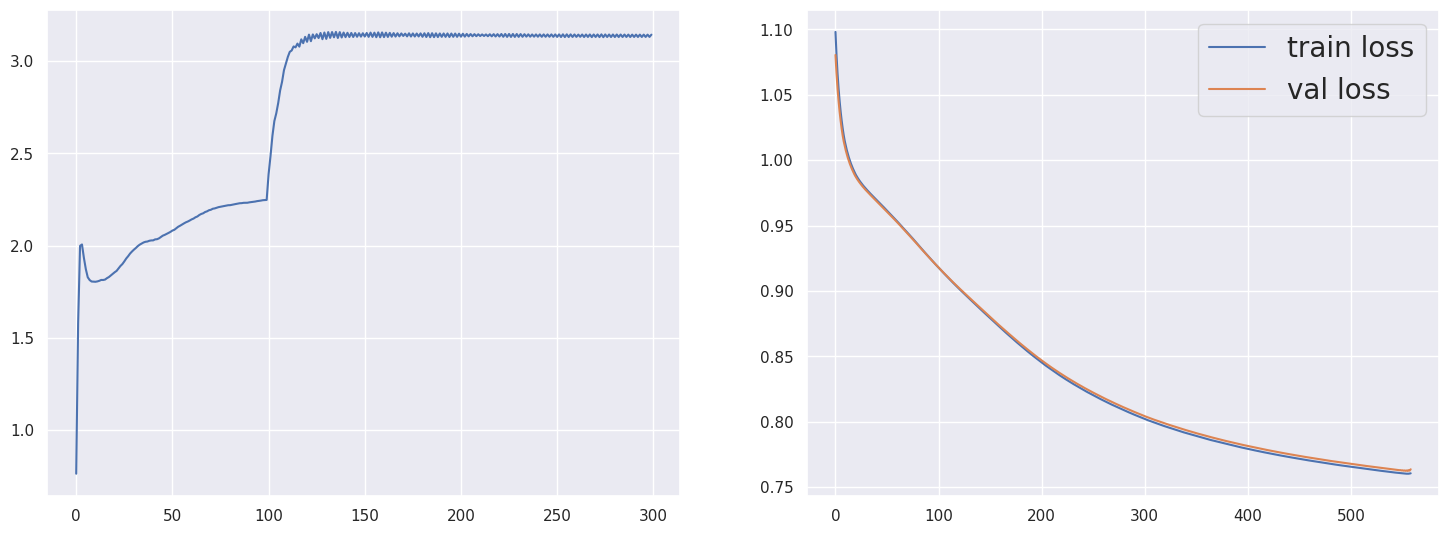

2
Behavior Model Final Training Loss: 0.743
End Epoch: 697


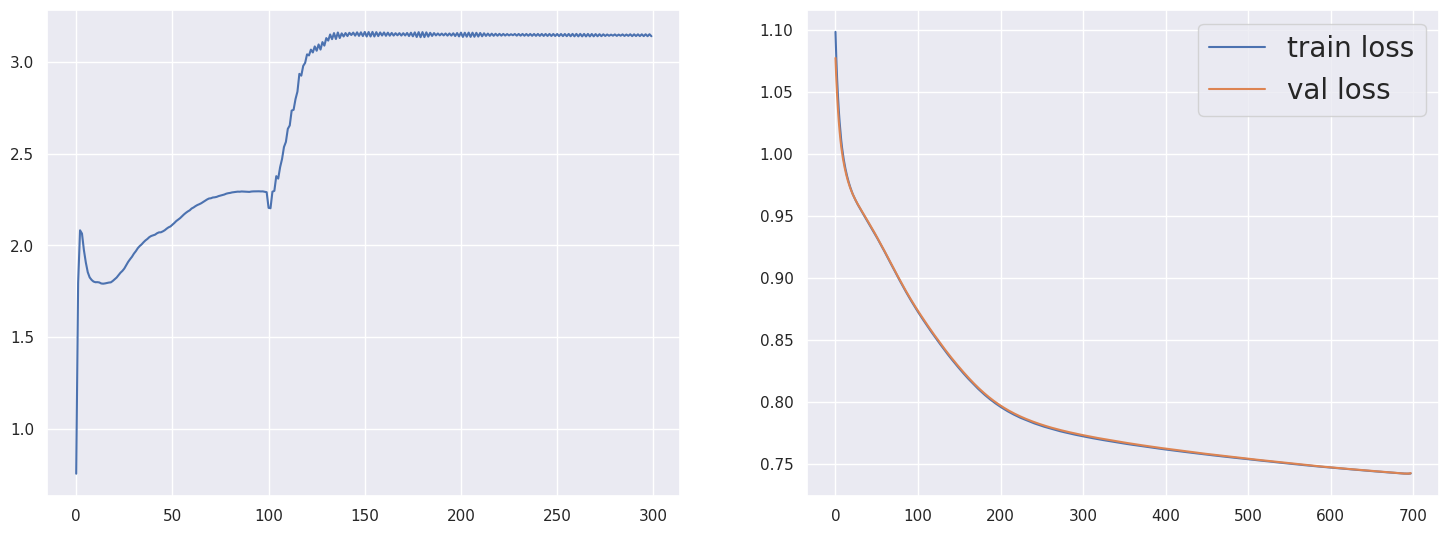

3
Behavior Model Final Training Loss: 0.749
End Epoch: 561


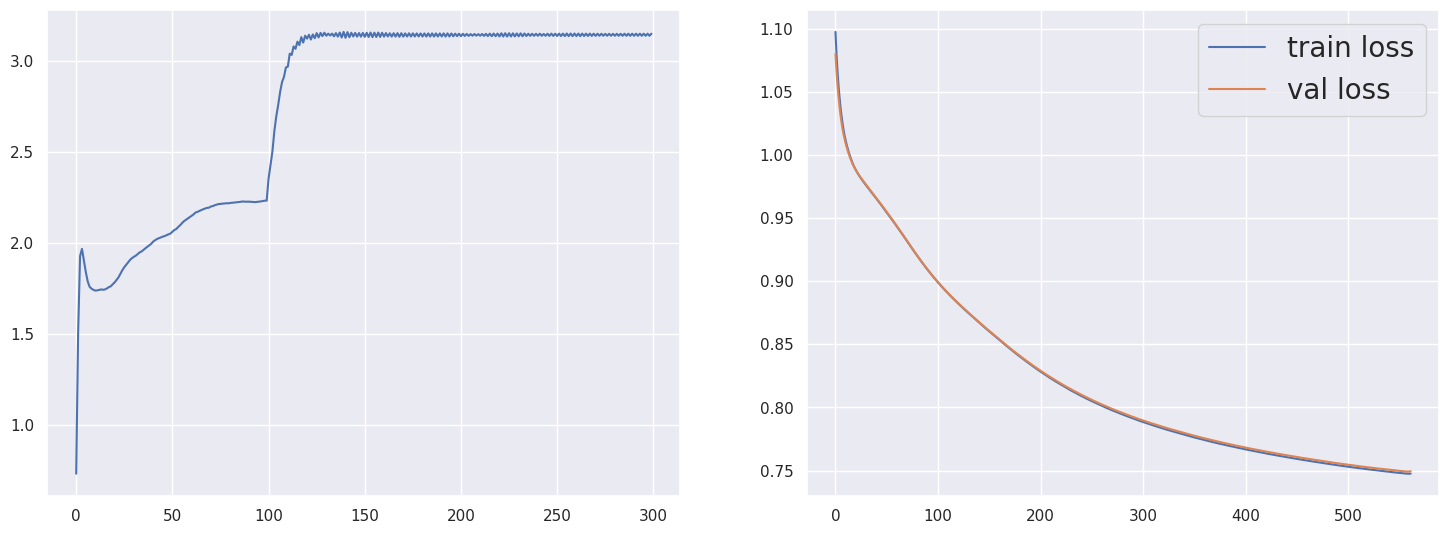

4
Behavior Model Final Training Loss: 0.760
End Epoch: 582


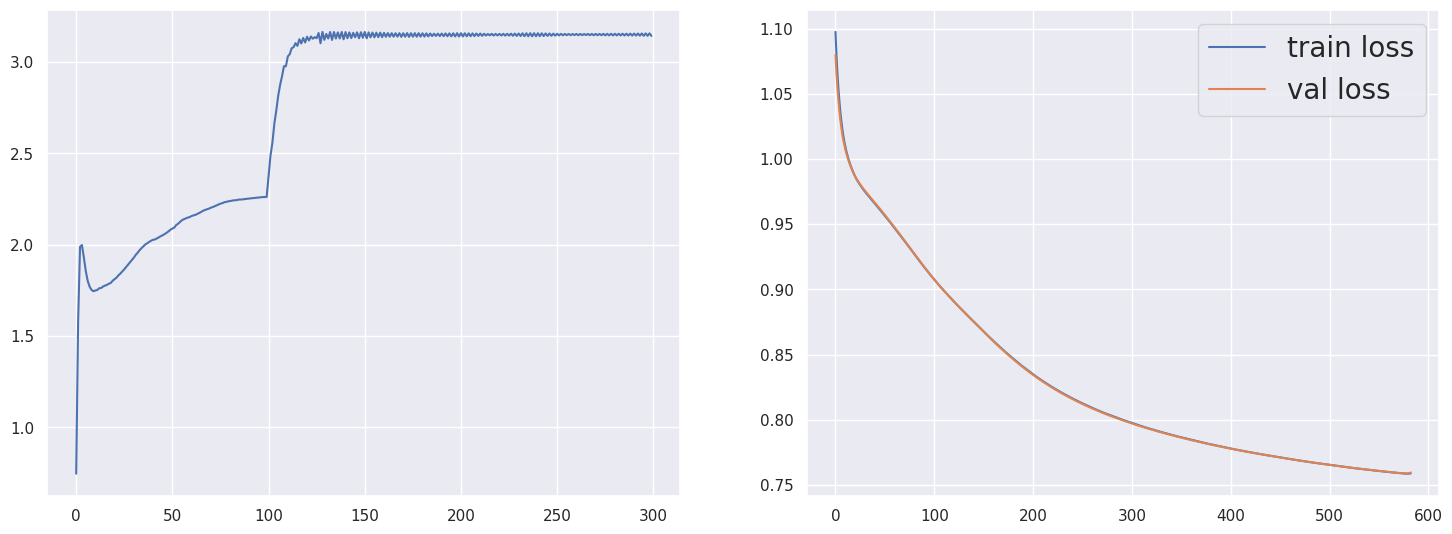

2
0
Behavior Model Final Training Loss: 0.460
End Epoch: 499


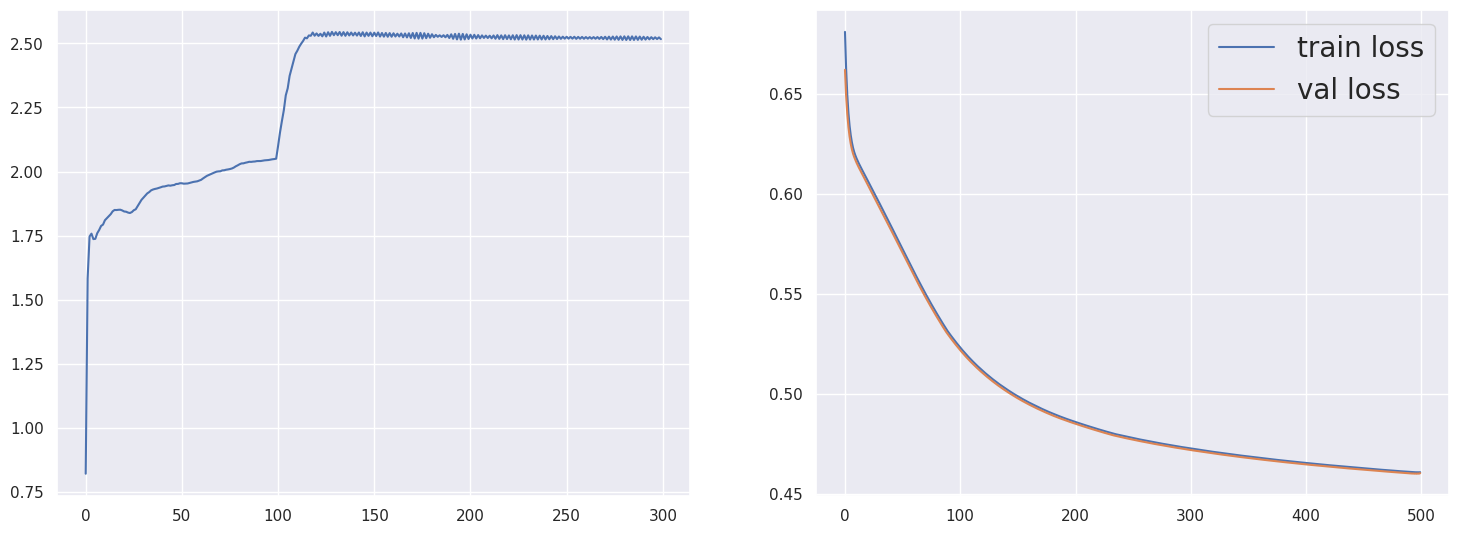

1
Behavior Model Final Training Loss: 0.437
End Epoch: 488


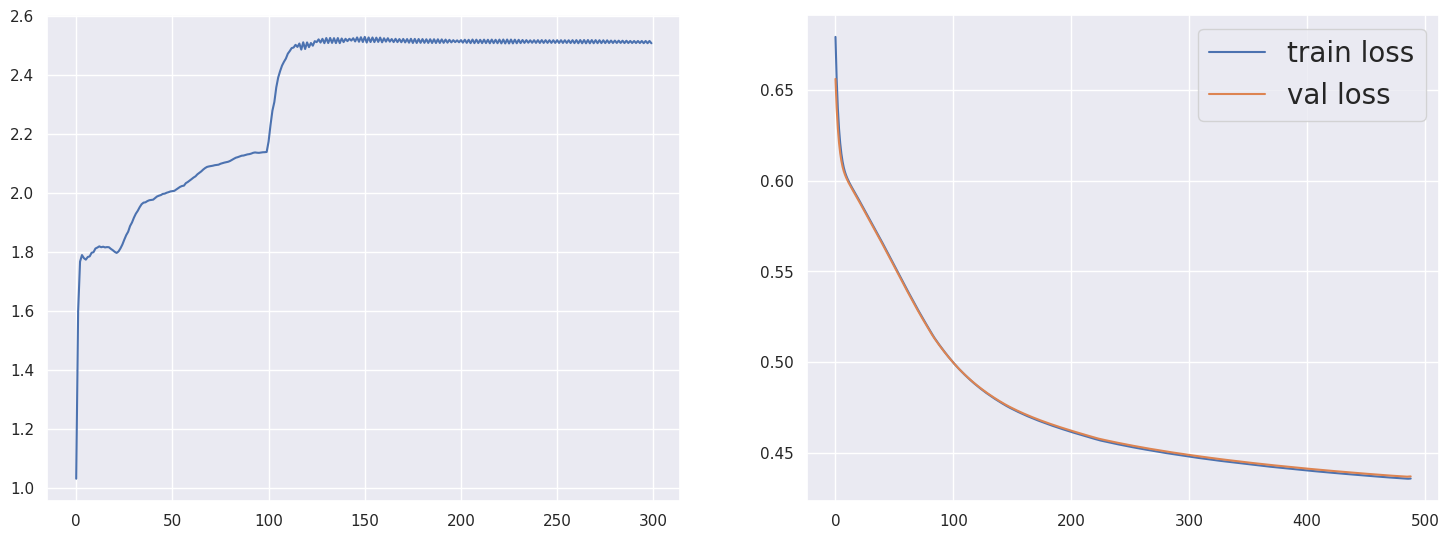

2
Behavior Model Final Training Loss: 0.465
End Epoch: 496


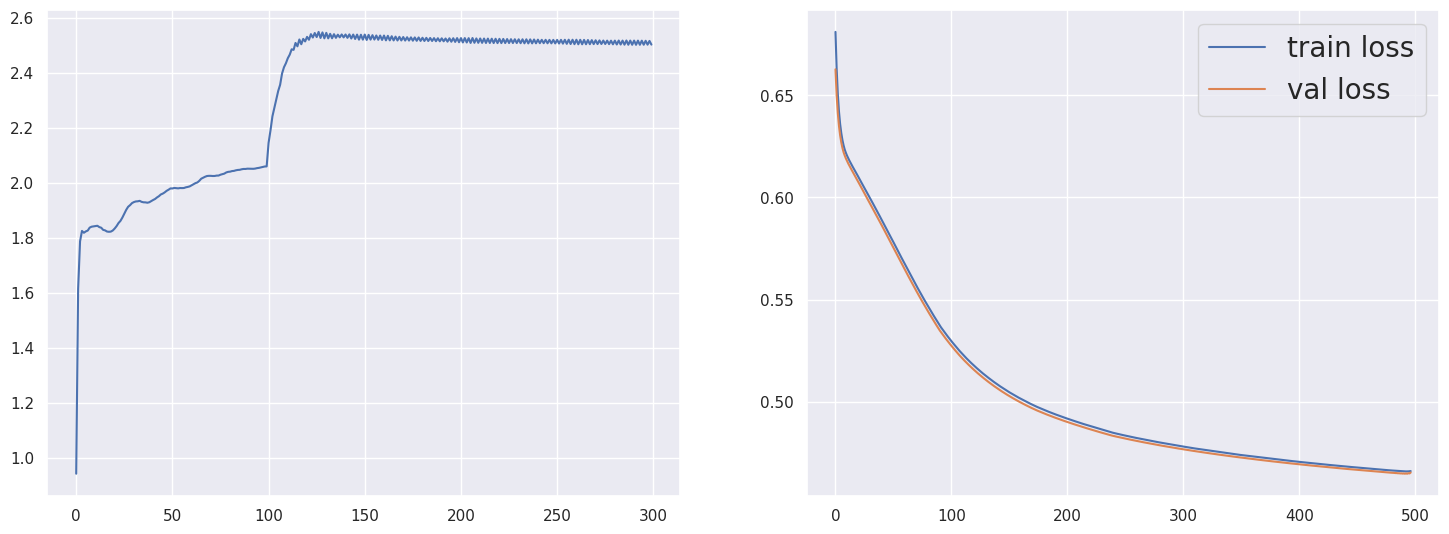

3
Behavior Model Final Training Loss: 0.462
End Epoch: 466


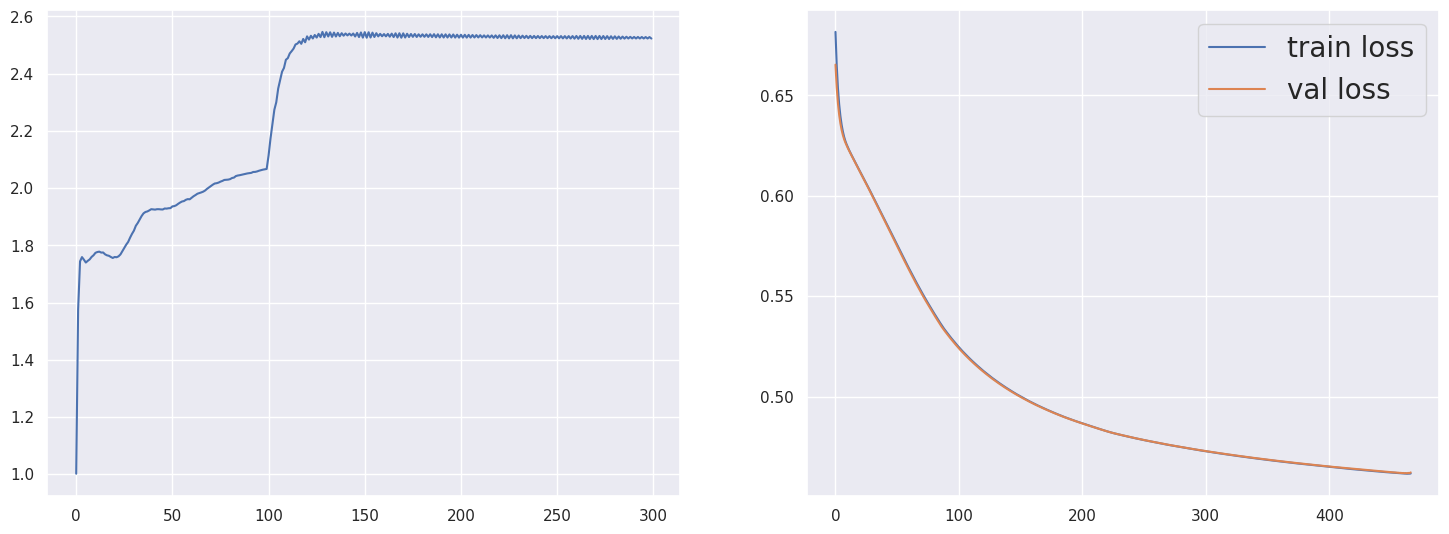

4
Behavior Model Final Training Loss: 0.474
End Epoch: 493


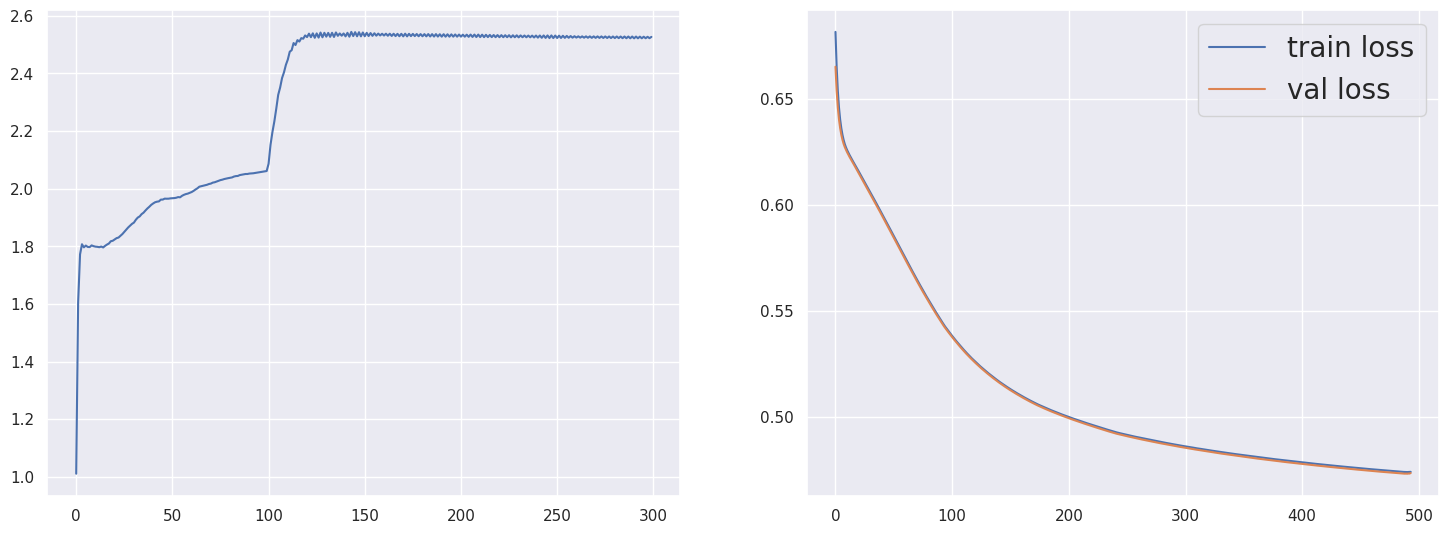

In [7]:
coarse_spg_cv_list3 = []


# for card_u in [8, 6, 4, 2]:
for card_u in [10, 5, 4, 3, 2]:
    print(card_u)   
    # u_coarse_vol = (true_card_u) // card_u # ceiling
    u_coarse_vol = (true_card_u + card_u - 1) // card_u # ceiling

    spg_cv = []
    init_seed = 0


    for rep_index in range(5):
        spg_curve = StrategicGD_coarse(cost_coef=cost_coef, f=10000, lr_pi=0.04, lr_prob=0.1, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, trans=trans, H=H, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                

        coarse_spg_cv_list3.append(spg_curve)    

In [8]:
torch.save(coarse_spg_cv_list3, "coarse_spg_cv_list_true_2-10card{}_rep5.pkl".format(true_card_u))